In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Part I

In [2]:
a = 1.0  
T = 2.0  
X = 10.0  

In [3]:
def phi(x):
    """u(0,x) = phi(x)"""
    return np.sin(np.pi * x / X)

def psi(t):
    """u(t,0) = psi(t)"""
    return 0.0

def f(t, x):
    return 0.0  

def analytical_solution(t, x):
    """
    u(t,x) = phi(x - a*t) for x - a*t >= 0
    u(t,x) = psi(t - x/a) for x - a*t < 0
    
    Для нашего случая phi(x) = sin(πx/X) and psi(t) = 0:
    u(t,x) = sin(π(x-a*t)/X) for x >= a*t
    u(t,x) = 0 for x < a*t
    """
    result = np.zeros_like(x)
    mask = x >= a * t
    result[mask] = phi(x[mask] - a * t)
    return result


In [4]:
# ugolok
def corner_scheme(K, M):
    """
    (u[k+1,m] - u[k,m])/τ + a*(u[k,m] - u[k,m-1])/h = f[k,m]
    """
    tau = T / K  
    h = X / M    
    
    if a * tau / h > 1:
        print(f"Warning: Scheme is unstable! CFL = {a * tau / h} > 1")
    
    u = np.zeros((K+1, M+1))
    
    for m in range(M+1):
        u[0, m] = phi(m * h)
    
    for k in range(K+1):
        u[k, 0] = psi(k * tau)
    
    for k in range(K):
        for m in range(1, M+1):
            u[k+1, m] = u[k, m] - a * tau / h * (u[k, m] - u[k, m-1]) + tau * f(k * tau, m * h)
    
    return u

# pryamougolnik
def rectangle_scheme(K, M):
    """
    (u[k+1,m-1] - u[k,m-1] + u[k+1,m] - u[k,m])/2τ + 
    a*(u[k+1,m] - u[k+1,m-1] + u[k,m] - u[k,m-1])/2h = f[k+1/2,m-1/2]
    """
    tau = T / K  
    h = X / M    
    
    u = np.zeros((K+1, M+1))
    
    for m in range(M+1):
        u[0, m] = phi(m * h)
    
    for k in range(K+1):
        u[k, 0] = psi(k * tau)
    
    for k in range(K):
        b = np.zeros(M)
        
        for m in range(1, M+1):
            f_val = f((k + 0.5) * tau, (m - 0.5) * h)  
            
            if m == 1:
                b[m-1] = (u[k, m-1] + u[k, m]) / 2 - a * tau / h * (u[k, m] - u[k, m-1]) / 2 + tau * f_val
                b[m-1] += a * tau / (2 * h) * u[k+1, 0]
            else:
                b[m-1] = (u[k, m-1] + u[k, m]) / 2 - a * tau / h * (u[k, m] - u[k, m-1]) / 2 + tau * f_val
        
        alpha = -a * tau / (2 * h)
        beta = 1 + a * tau / (2 * h)
        
        c_prime = np.zeros(M)
        d_prime = np.zeros(M)
        
        c_prime[0] = alpha / beta
        d_prime[0] = b[0] / beta
        
        for i in range(1, M-1):
            c_prime[i] = alpha / (beta - alpha * c_prime[i-1])
            d_prime[i] = (b[i] - alpha * d_prime[i-1]) / (beta - alpha * c_prime[i-1])
        
        d_prime[M-1] = (b[M-1] - alpha * d_prime[M-2]) / (beta - alpha * c_prime[M-2])
        
        # Back-substitution
        u[k+1, M] = d_prime[M-1]
        for m in range(M-1, 0, -1):
            u[k+1, m] = d_prime[m-1] - c_prime[m-1] * u[k+1, m+1]
    
    return u

def lax_wendroff_scheme(K, M):
    """
    (u[k+1,m] - u[k,m])/τ + a*(u[k,m+1] - u[k,m-1])/2h - 
    0.5*a^2*τ*(u[k,m+1] - 2*u[k,m] + u[k,m-1])/h^2 = f[k,m]
    """
    tau = T / K  
    h = X / M    
    
    if a * tau / h > 1:
        print(f"Warning: Scheme may be unstable! CFL = {a * tau / h} > 1")
    
    u = np.zeros((K+1, M+1))
    
    for m in range(M+1):
        u[0, m] = phi(m * h)
    
    for k in range(K+1):
        u[k, 0] = psi(k * tau)
    
    for k in range(K):
        u[k+1, 1] = u[k, 1] - 0.5 * a * tau / h * (2 * u[k, 1] - 2 * u[k, 0]) + \
                   0.5 * (a * tau / h)**2 * (u[k, 2] - 2 * u[k, 1] + u[k, 0]) + \
                   tau * f(k * tau, h)
        
        for m in range(1, M):
            u[k+1, m] = u[k, m] - 0.5 * a * tau / h * (u[k, m+1] - u[k, m-1]) + \
                       0.5 * (a * tau / h)**2 * (u[k, m+1] - 2 * u[k, m] + u[k, m-1]) + \
                       tau * f(k * tau, m * h)
        
        u[k+1, M] = 2 * u[k+1, M-1] - u[k+1, M-2]
    
    return u

In [6]:
def compute_error(numerical_sol, analytical_sol):
    """
    Compute the L2 norm of the error between numerical and analytical solutions.
    """
    return np.sqrt(np.mean((numerical_sol - analytical_sol) ** 2))

def run_convergence_analysis(scheme_func, scheme_name):
    """
    Perform convergence analysis for a given scheme.
    """

    grid_sizes = [20, 40, 80, 160, 320]
    errors = []
    
    for N in grid_sizes:
        K = N  
        M = N
        
        u = scheme_func(K, M)
        
        x_values = np.linspace(0, X, M+1)
        u_analytical = analytical_solution(T, x_values)
        
        error = compute_error(u[-1, :], u_analytical)
        errors.append(error)
        
        print(f"{scheme_name} - Grid {N}x{N}: Error = {error:.6e}")
    
    convergence_orders = []
    for i in range(1, len(grid_sizes)):
        order = np.log(errors[i-1] / errors[i]) / np.log(grid_sizes[i] / grid_sizes[i-1])
        convergence_orders.append(order)
        print(f"Convergence order from {grid_sizes[i-1]} to {grid_sizes[i]}: {order:.3f}")
    
    plt.figure(figsize=(10, 6))
    plt.loglog(grid_sizes, errors, 'o-', label=f'{scheme_name}')
    
    min_grid = grid_sizes[0]
    max_grid = grid_sizes[-1]
    ref_grids = np.logspace(np.log10(min_grid), np.log10(max_grid), 100)
    
    scale_factor_1st = errors[0] / (min_grid ** -1)
    scale_factor_2nd = errors[0] / (min_grid ** -2)
    
    plt.loglog(ref_grids, scale_factor_1st * ref_grids ** -1, '--', label='1st Order')
    plt.loglog(ref_grids, scale_factor_2nd * ref_grids ** -2, ':', label='2nd Order')
    
    plt.xlabel('Grid Size (N)')
    plt.ylabel('L2 Error')
    plt.title(f'Convergence Analysis - {scheme_name}')
    plt.grid(True)
    plt.legend()

    plt.show()
    
    return errors, convergence_orders

def plot_solution_comparison(K, M):
    """
    Plot and compare solutions from different schemes with the analytical solution.
    """
    u_corner = corner_scheme(K, M)
    u_rectangle = rectangle_scheme(K, M)
    u_laxwendroff = lax_wendroff_scheme(K, M)
    
    x_values = np.linspace(0, X, M+1)
    u_analytical = analytical_solution(T, x_values)
    
    plt.figure(figsize=(12, 8))
    plt.plot(x_values, u_analytical, 'k-', linewidth=2, label='Analytical')
    plt.plot(x_values, u_corner[-1, :], 'r--', label='Corner Scheme')
    plt.plot(x_values, u_rectangle[-1, :], 'g-.', label='Rectangle Scheme')
    plt.plot(x_values, u_laxwendroff[-1, :], 'b:', label='Lax-Wendroff Scheme')
    
    plt.xlabel('x')
    plt.ylabel('u(T,x)')
    plt.title(f'Comparison of Numerical Schemes at t = {T} (Grid {M}x{K})')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'solution_comparison_{M}.png')
    
    error_corner = compute_error(u_corner[-1, :], u_analytical)
    error_rectangle = compute_error(u_rectangle[-1, :], u_analytical)
    error_laxwendroff = compute_error(u_laxwendroff[-1, :], u_analytical)
    
    print(f"Grid {M}x{K} Errors:")
    print(f"Corner Scheme: {error_corner:.6e}")
    print(f"Rectangle Scheme: {error_rectangle:.6e}")
    print(f"Lax-Wendroff Scheme: {error_laxwendroff:.6e}")
    
    t_values = np.linspace(0, T, K+1)
    T_grid, X_grid = np.meshgrid(t_values, x_values)
    
    for idx, (u, name) in enumerate([
        (u_corner.T, 'Corner Scheme'),
        (u_rectangle.T, 'Rectangle Scheme'),
        (u_laxwendroff.T, 'Lax-Wendroff Scheme')
    ]):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(T_grid, X_grid, u, cmap=cm.viridis, linewidth=0, antialiased=False)
        
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Space (x)')
        ax.set_zlabel('u(t,x)')
        ax.set_title(f'3D Solution - {name}')
        fig.colorbar(surf, shrink=0.5, aspect=5)


        plt.show()


Grid 100x100 Errors:
Corner Scheme: 9.892063e-03
Rectangle Scheme: 1.445064e+04
Lax-Wendroff Scheme: 2.923248e-03


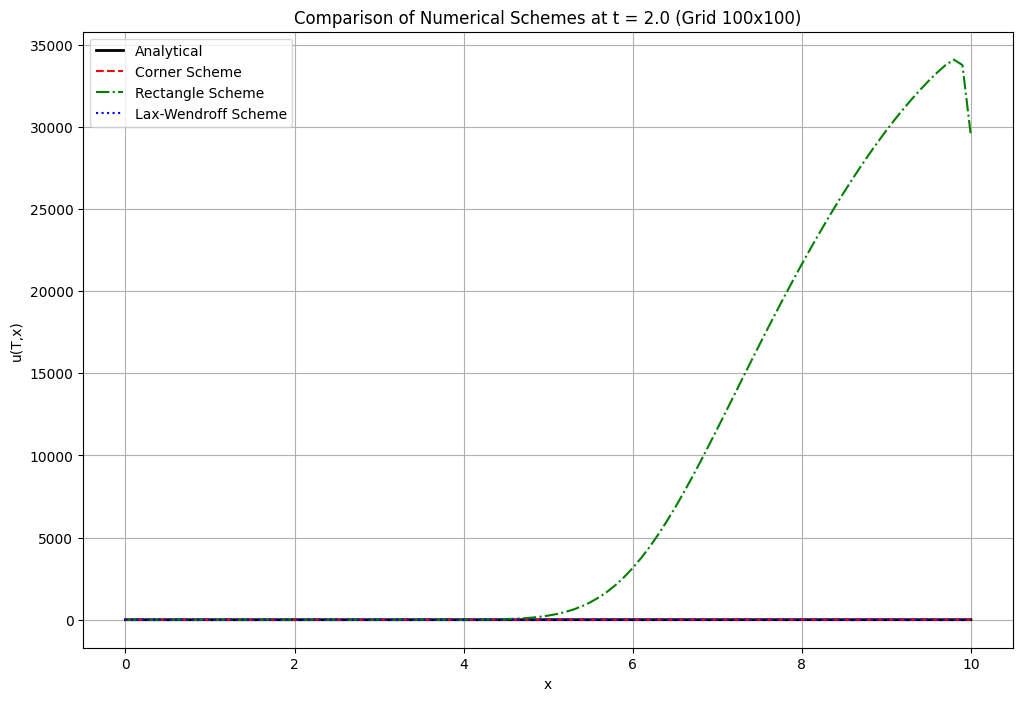

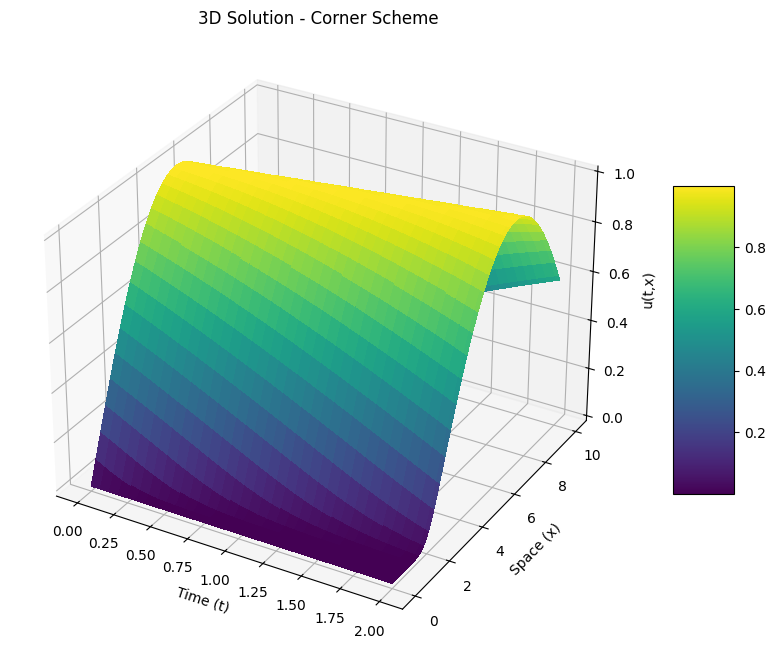

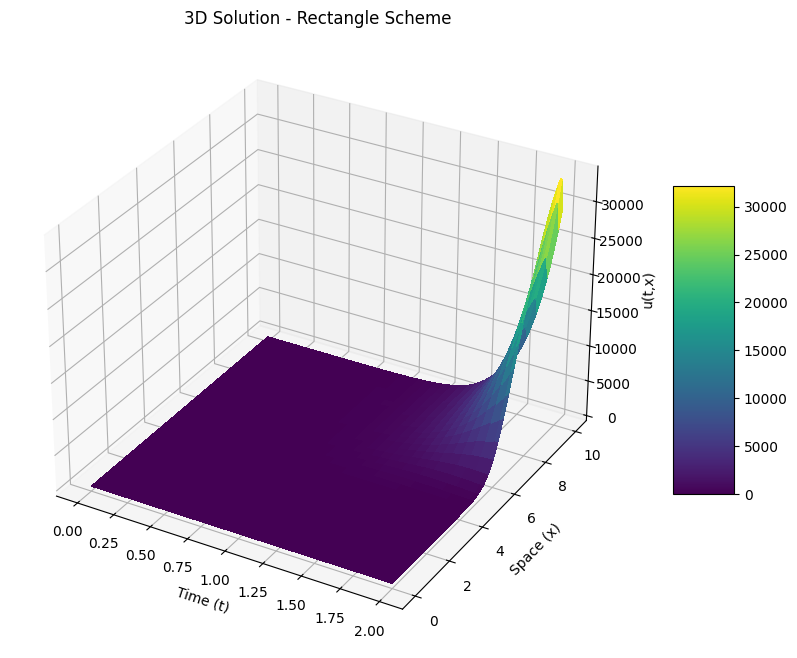

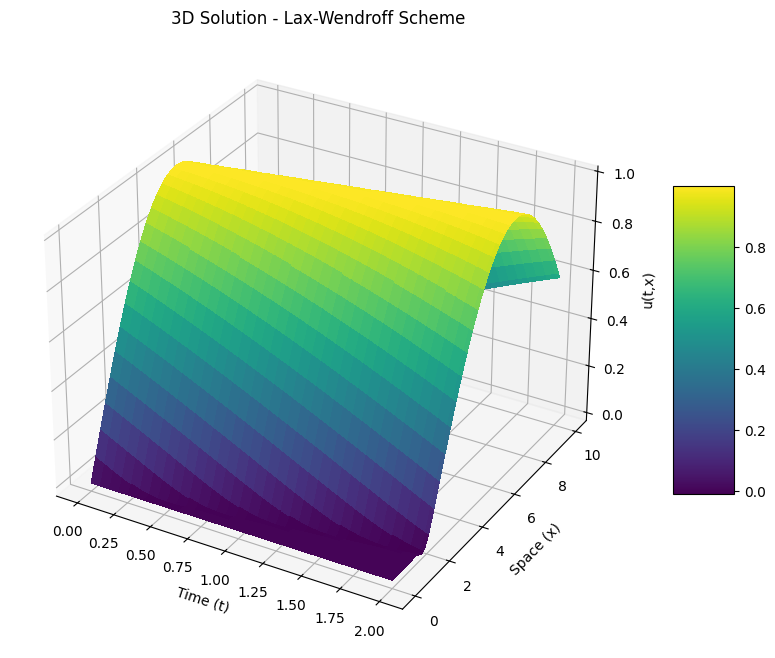


Convergence Analysis - Corner Scheme:
Corner Scheme - Grid 20x20: Error = 3.766841e-02
Corner Scheme - Grid 40x40: Error = 2.108545e-02
Corner Scheme - Grid 80x80: Error = 1.187774e-02
Corner Scheme - Grid 160x160: Error = 6.750121e-03
Corner Scheme - Grid 320x320: Error = 3.871214e-03
Convergence order from 20 to 40: 0.837
Convergence order from 40 to 80: 0.828
Convergence order from 80 to 160: 0.815
Convergence order from 160 to 320: 0.802


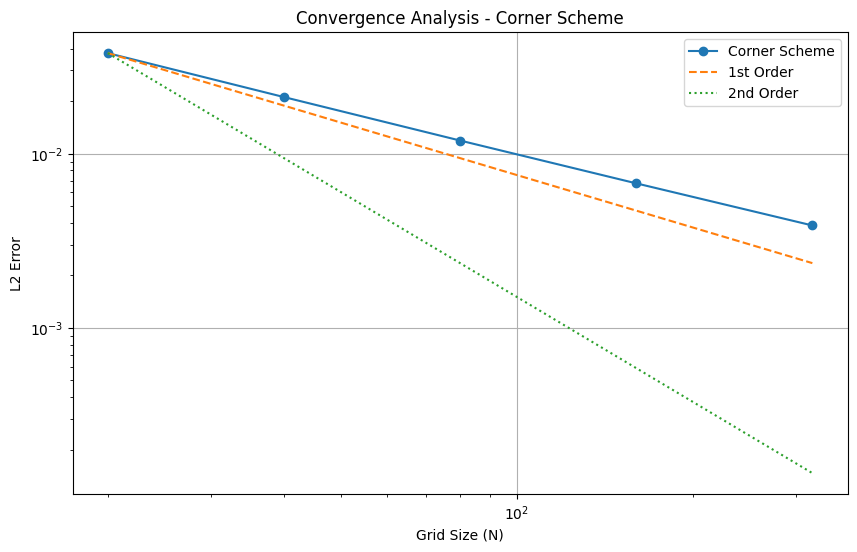


Convergence Analysis - Rectangle Scheme:
Rectangle Scheme - Grid 20x20: Error = 2.485162e+00
Rectangle Scheme - Grid 40x40: Error = 2.483794e+01
Rectangle Scheme - Grid 80x80: Error = 1.748726e+03
Rectangle Scheme - Grid 160x160: Error = 8.097382e+06
Rectangle Scheme - Grid 320x320: Error = 1.706830e+14
Convergence order from 20 to 40: -3.321
Convergence order from 40 to 80: -6.138
Convergence order from 80 to 160: -12.177
Convergence order from 160 to 320: -24.329


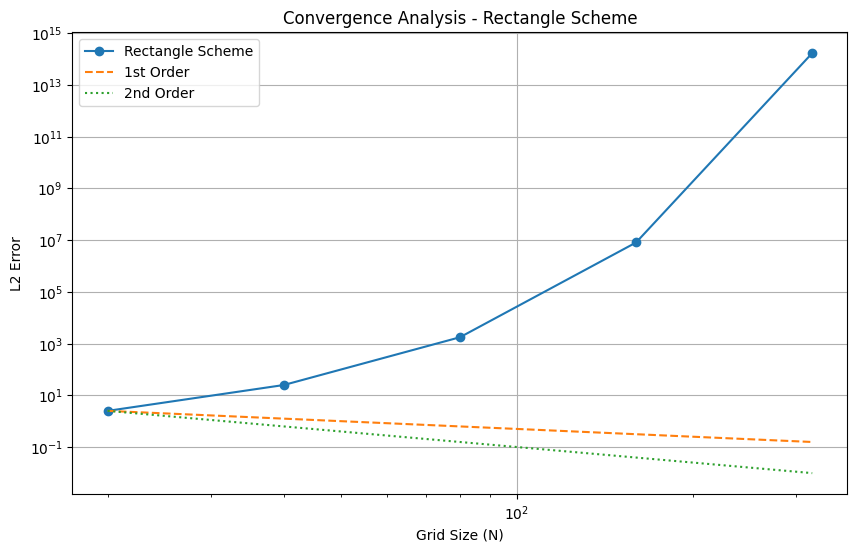


Convergence Analysis - Lax-Wendroff Scheme:
Lax-Wendroff Scheme - Grid 20x20: Error = 1.479291e-02
Lax-Wendroff Scheme - Grid 40x40: Error = 7.249900e-03
Lax-Wendroff Scheme - Grid 80x80: Error = 3.642554e-03
Lax-Wendroff Scheme - Grid 160x160: Error = 1.840684e-03
Lax-Wendroff Scheme - Grid 320x320: Error = 9.309341e-04
Convergence order from 20 to 40: 1.029
Convergence order from 40 to 80: 0.993
Convergence order from 80 to 160: 0.985
Convergence order from 160 to 320: 0.983


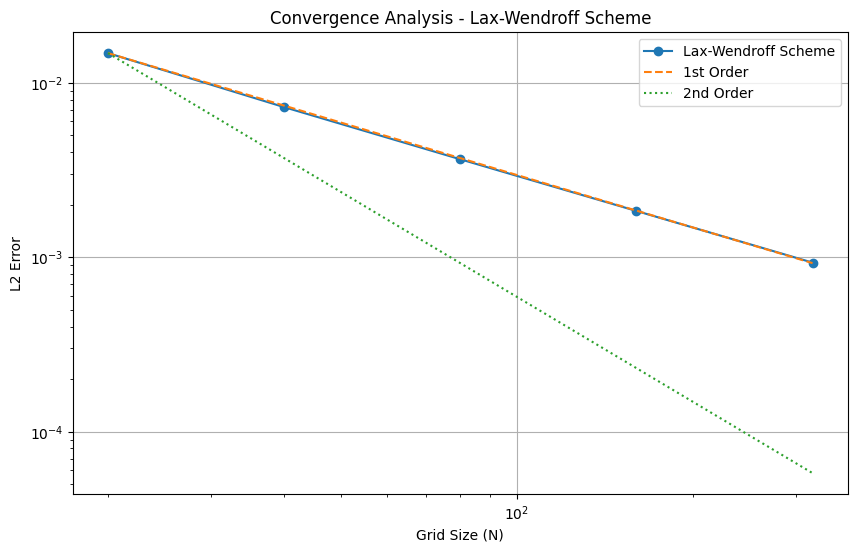

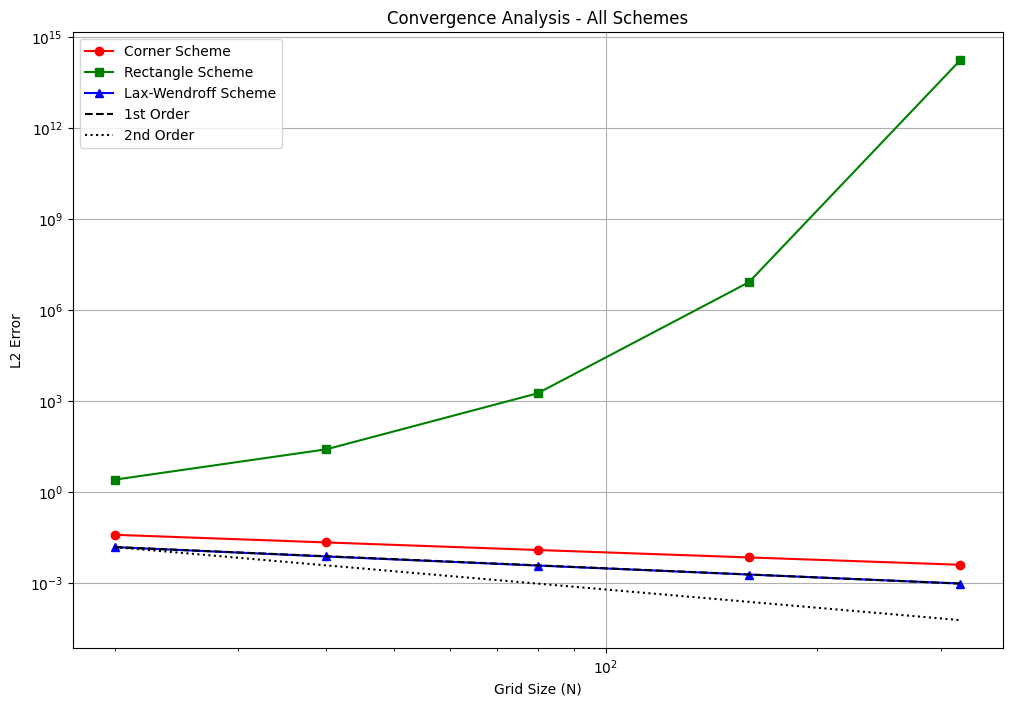

In [7]:
plot_solution_comparison(100, 100)

print("\nConvergence Analysis - Corner Scheme:")
errors_corner, orders_corner = run_convergence_analysis(corner_scheme, "Corner Scheme")

print("\nConvergence Analysis - Rectangle Scheme:")
errors_rectangle, orders_rectangle = run_convergence_analysis(rectangle_scheme, "Rectangle Scheme")

print("\nConvergence Analysis - Lax-Wendroff Scheme:")
errors_laxwendroff, orders_laxwendroff = run_convergence_analysis(lax_wendroff_scheme, "Lax-Wendroff Scheme")

grid_sizes = [20, 40, 80, 160, 320]
plt.figure(figsize=(12, 8))
plt.loglog(grid_sizes, errors_corner, 'ro-', label='Corner Scheme')
plt.loglog(grid_sizes, errors_rectangle, 'gs-', label='Rectangle Scheme')
plt.loglog(grid_sizes, errors_laxwendroff, 'b^-', label='Lax-Wendroff Scheme')

min_grid = grid_sizes[0]
max_grid = grid_sizes[-1]
ref_grids = np.logspace(np.log10(min_grid), np.log10(max_grid), 100)

scale_factor_1st = min(errors_corner[0], errors_rectangle[0], errors_laxwendroff[0]) / (min_grid ** -1)
scale_factor_2nd = min(errors_corner[0], errors_rectangle[0], errors_laxwendroff[0]) / (min_grid ** -2)

plt.loglog(ref_grids, scale_factor_1st * ref_grids ** -1, 'k--', label='1st Order')
plt.loglog(ref_grids, scale_factor_2nd * ref_grids ** -2, 'k:', label='2nd Order')

plt.xlabel('Grid Size (N)')
plt.ylabel('L2 Error')
plt.title('Convergence Analysis - All Schemes')
plt.grid(True)
plt.legend()

# Part II

10. численное решение двумерного уравнения теплопроводности:

∂u/∂t = ∂²u/∂x² + ∂²u/∂y², 0≤x≤1, 0≤y≤1

с граничными условиями:
* u(0,x,y) = 0 
* u(t,0,y) = 0 
* u(t,1,y) = 1 
* u(t,x,0) = 2 
* u(t,x,1) = 3 

### Реализованные разностные схемы

1. **Явная схема** (схема "а" ):
   ```
   (u^{n+1}_ml - u^n_ml)/τ = Λ₁ū_ml
   (u^{n+1}_ml - ū_ml)/τ = Λ₂u^{n+1}_ml
   ```

2. **Схема с весами** (схема "б"):
   ```
   (u^{n+1/2}_ml - u^n_ml)/τ = Λ₁[ξu^{n+1/2}_ml + (1-ξ)u^n_ml]
   (u^{n+1}_ml - u^{n+1/2}_ml)/τ = Λ₂[ξu^{n+1}_ml + (1-ξ)u^{n+1/2}_ml], ξ = 1/2
   ```

3. **Схема Кранка-Николсона** (схема "в"):
   ```
   (ū_ml-u^n_ml)/τ = 1/2(Λ₁ū_ml+Λ₂u^n_ml)
   (u^{n+1}_ml-u^{n+1/2}_ml)/τ = 1/2(Λ₁ū_ml+Λ₂u^{n+1}_ml)
   ```

4. **Полностью неявная схема** (схема "г"):
   ```
   (ū_ml-u^n_ml)/τ = Λ₁u^n_ml
   (u^{n+1}_ml-ū_ml)/τ = Λ₂ū_ml
   ```

In [8]:
T_max = 0.2  
X_max = 1.0  
Y_max = 1.0  

In [9]:
def initial_condition(x, y):
    return np.zeros_like(x)

def boundary_left(t, y):
    return np.zeros_like(y)

def boundary_right(t, y):
    return np.ones_like(y)

def boundary_bottom(t, x):
    return 2 * np.ones_like(x)

def boundary_top(t, x):
    return 3 * np.ones_like(x)

def initialize_grid(Nx, Ny):
    u = np.zeros((Nx+1, Ny+1))
    x = np.linspace(0, X_max, Nx+1)
    y = np.linspace(0, Y_max, Ny+1)
    
    for i in range(1, Nx):
        for j in range(1, Ny):
            u[i, j] = initial_condition(x[i], y[j])
    
    for j in range(Ny+1):
        u[0, j] = boundary_left(0, y[j])
        u[Nx, j] = boundary_right(0, y[j])
    
    for i in range(Nx+1):
        u[i, 0] = boundary_bottom(0, x[i])
        u[i, Ny] = boundary_top(0, x[i])
    
    return u, x, y

def update_boundaries(u, t, x, y):
    Nx, Ny = len(x)-1, len(y)-1
    
    for j in range(Ny+1):
        u[0, j] = boundary_left(t, y[j])
        u[Nx, j] = boundary_right(t, y[j])
    
    for i in range(Nx+1):
        u[i, 0] = boundary_bottom(t, x[i])
        u[i, Ny] = boundary_top(t, x[i])
    
    return u

In [10]:
def solve_explicit_scheme(Nx, Ny, Nt):
    """
    (u^{n+1}_ml - u^n_ml)/τ = Λ₁ū_ml, (u^{n+1}_ml - ū_ml)/τ = Λ₂u^{n+1}_ml
    """
    dx = X_max / Nx
    dy = Y_max / Ny
    
    # Для явной схемы должно быть dt <= 0.5*dx^2 и dt <= 0.5*dy^2
    dt_max = 0.4 * min(dx**2, dy**2)  
    Nt_adjusted = max(Nt, int(np.ceil(T_max / dt_max)))
    dt = T_max / Nt_adjusted
    
    print(f"Шаг по времени: dt = {dt:.6e}, число временных шагов: {Nt_adjusted}")
    print(f"Условие устойчивости: dt/(dx²) = {dt/dx**2:.6f}, dt/(dy²) = {dt/dy**2:.6f} (должно быть <= 0.5)")
    
    u, x, y = initialize_grid(Nx, Ny)
    u_history = [u.copy()]
    
    for n in range(Nt_adjusted):
        t = (n+1) * dt
        
        u_intermediate = u.copy()
        
        for j in range(1, Ny):
            for i in range(1, Nx):
                u_intermediate[i, j] = u[i, j] + dt/dx**2 * (u[i+1, j] - 2*u[i, j] + u[i-1, j])
        
        u_intermediate = update_boundaries(u_intermediate, t, x, y)
        
        u_new = u_intermediate.copy()
        
        for j in range(1, Ny):
            for i in range(1, Nx):
                u_new[i, j] = u_intermediate[i, j] + dt/dy**2 * (u_intermediate[i, j+1] - 2*u_intermediate[i, j] + u_intermediate[i, j-1])
        
        u_new = update_boundaries(u_new, t, x, y)
        
        u = u_new.copy()
        
        if n * Nt // Nt_adjusted >= len(u_history) - 1 and len(u_history) < Nt + 1:
            u_history.append(u.copy())
    
    while len(u_history) < Nt + 1:
        u_history.append(u.copy())
    
    return u_history, x, y

def solve_weighted_scheme(Nx, Ny, Nt, xi=0.5):
    """
    (u^{n+1/2}_ml - u^n_ml)/τ = Λ₁[ξu^{n+1/2}_ml + (1-ξ)u^n_ml]
    (u^{n+1}_ml - u^{n+1/2}_ml)/τ = Λ₂[ξu^{n+1}_ml + (1-ξ)u^{n+1/2}_ml], ξ = 1/2
    """
    dx = X_max / Nx
    dy = Y_max / Ny
    dt = T_max / Nt
    
    print(f"Шаг по времени: dt = {dt:.6e}, число временных шагов: {Nt}")
    
    u, x, y = initialize_grid(Nx, Ny)
    u_history = [u.copy()]
    
    Ax = np.zeros((Nx-1, Nx-1))
    for i in range(Nx-1):
        Ax[i, i] = 1 + 2*xi*dt/dx**2
        if i > 0:
            Ax[i, i-1] = -xi*dt/dx**2
        if i < Nx-2:
            Ax[i, i+1] = -xi*dt/dx**2
    
    Ay = np.zeros((Ny-1, Ny-1))
    for j in range(Ny-1):
        Ay[j, j] = 1 + 2*xi*dt/dy**2
        if j > 0:
            Ay[j, j-1] = -xi*dt/dy**2
        if j < Ny-2:
            Ay[j, j+1] = -xi*dt/dy**2
    
    for n in range(Nt):
        t = (n+1) * dt
        
        u_intermediate = np.zeros((Nx+1, Ny+1))
        u_intermediate[0, :] = boundary_left(t, y)
        u_intermediate[Nx, :] = boundary_right(t, y)
        u_intermediate[:, 0] = boundary_bottom(t, x)
        u_intermediate[:, Ny] = boundary_top(t, x)
        
        for j in range(1, Ny):
            b = np.zeros(Nx-1)
            for i in range(1, Nx):
                b[i-1] = u[i, j] + (1-xi)*dt/dx**2 * (u[i+1, j] - 2*u[i, j] + u[i-1, j])
            
            b[0] += xi*dt/dx**2 * boundary_left(t, y[j])
            b[-1] += xi*dt/dx**2 * boundary_right(t, y[j])
            
            u_intermediate[1:Nx, j] = np.linalg.solve(Ax, b)
        
        u_new = np.zeros((Nx+1, Ny+1))
        u_new = update_boundaries(u_new, t, x, y)
        
        for i in range(1, Nx):
            b = np.zeros(Ny-1)
            for j in range(1, Ny):
                b[j-1] = u_intermediate[i, j] + (1-xi)*dt/dy**2 * (u_intermediate[i, j+1] - 2*u_intermediate[i, j] + u_intermediate[i, j-1])
            
            b[0] += xi*dt/dy**2 * boundary_bottom(t, x[i])
            b[-1] += xi*dt/dy**2 * boundary_top(t, x[i])
            
            u_new[i, 1:Ny] = np.linalg.solve(Ay, b)
        
        u = u_new.copy()
        u_history.append(u.copy())
    
    return u_history, x, y

def solve_crank_nicolson_scheme(Nx, Ny, Nt):
    """
    (ū_ml-u^n_ml)/τ = 1/2(Λ₁ū_ml+Λ₂u^n_ml)
    (u^{n+1}_ml-u^{n+1/2}_ml)/τ = 1/2(Λ₁ū_ml+Λ₂u^{n+1}_ml)
    """
    dx = X_max / Nx
    dy = Y_max / Ny
    dt = T_max / Nt
    
    print(f"Шаг по времени: dt = {dt:.6e}, число временных шагов: {Nt}")
    
    u, x, y = initialize_grid(Nx, Ny)
    u_history = [u.copy()]
    
    alpha_x = dt / (2 * dx**2)
    alpha_y = dt / (2 * dy**2)
    
    Ax = np.zeros((Nx-1, Nx-1))
    for i in range(Nx-1):
        Ax[i, i] = 1 + 2*alpha_x
        if i > 0:
            Ax[i, i-1] = -alpha_x
        if i < Nx-2:
            Ax[i, i+1] = -alpha_x
    
    Ay = np.zeros((Ny-1, Ny-1))
    for j in range(Ny-1):
        Ay[j, j] = 1 + 2*alpha_y
        if j > 0:
            Ay[j, j-1] = -alpha_y
        if j < Ny-2:
            Ay[j, j+1] = -alpha_y
    
    for n in range(Nt):
        t = (n+1) * dt
        
        u_intermediate = np.zeros((Nx+1, Ny+1))
        u_intermediate[0, :] = boundary_left(t, y)
        u_intermediate[Nx, :] = boundary_right(t, y)
        u_intermediate[:, 0] = boundary_bottom(t, x)
        u_intermediate[:, Ny] = boundary_top(t, x)
        
        for j in range(1, Ny):
            b = np.zeros(Nx-1)
            for i in range(1, Nx):
                b[i-1] = u[i, j] + alpha_x * (u[i+1, j] - 2*u[i, j] + u[i-1, j])
            
            b[0] += alpha_x * boundary_left(t, y[j])
            b[-1] += alpha_x * boundary_right(t, y[j])
            
            u_intermediate[1:Nx, j] = np.linalg.solve(Ax, b)
        
        u_new = np.zeros((Nx+1, Ny+1))
        u_new = update_boundaries(u_new, t, x, y)
        
        for i in range(1, Nx):
            b = np.zeros(Ny-1)
            for j in range(1, Ny):
                b[j-1] = u_intermediate[i, j] + alpha_y * (u_intermediate[i, j+1] - 2*u_intermediate[i, j] + u_intermediate[i, j-1])
            
            b[0] += alpha_y * boundary_bottom(t, x[i])
            b[-1] += alpha_y * boundary_top(t, x[i])
            
            u_new[i, 1:Ny] = np.linalg.solve(Ay, b)
        
        u = u_new.copy()
        u_history.append(u.copy())
    
    return u_history, x, y

def solve_fully_implicit_scheme(Nx, Ny, Nt):
    """
    (ū_ml-u^n_ml)/τ = Λ₁u^n_ml, (u^{n+1}_ml-ū_ml)/τ = Λ₂ū_ml
    """
    dx = X_max / Nx
    dy = Y_max / Ny
    dt = T_max / Nt
    
    print(f"Шаг по времени: dt = {dt:.6e}, число временных шагов: {Nt}")
    
    u, x, y = initialize_grid(Nx, Ny)
    u_history = [u.copy()]
    
    alpha_x = dt / dx**2
    alpha_y = dt / dy**2
    
    Ax = np.zeros((Nx-1, Nx-1))
    for i in range(Nx-1):
        Ax[i, i] = 1 + 2*alpha_x
        if i > 0:
            Ax[i, i-1] = -alpha_x
        if i < Nx-2:
            Ax[i, i+1] = -alpha_x
    
    Ay = np.zeros((Ny-1, Ny-1))
    for j in range(Ny-1):
        Ay[j, j] = 1 + 2*alpha_y
        if j > 0:
            Ay[j, j-1] = -alpha_y
        if j < Ny-2:
            Ay[j, j+1] = -alpha_y
    
    for n in range(Nt):
        t = (n+1) * dt
        
        u_intermediate = np.zeros((Nx+1, Ny+1))
        u_intermediate[0, :] = boundary_left(t, y)
        u_intermediate[Nx, :] = boundary_right(t, y)
        u_intermediate[:, 0] = boundary_bottom(t, x)
        u_intermediate[:, Ny] = boundary_top(t, x)
        
        for j in range(1, Ny):
            b = np.zeros(Nx-1)
            for i in range(1, Nx):
                b[i-1] = u[i, j]
            
            b[0] += alpha_x * boundary_left(t, y[j])
            b[-1] += alpha_x * boundary_right(t, y[j])
            
            u_intermediate[1:Nx, j] = np.linalg.solve(Ax, b)
        
        u_new = np.zeros((Nx+1, Ny+1))
        u_new = update_boundaries(u_new, t, x, y)
        
        for i in range(1, Nx):
            b = np.zeros(Ny-1)
            for j in range(1, Ny):
                b[j-1] = u_intermediate[i, j]
            
            b[0] += alpha_y * boundary_bottom(t, x[i])
            b[-1] += alpha_y * boundary_top(t, x[i])
            
            u_new[i, 1:Ny] = np.linalg.solve(Ay, b)
        
        u = u_new.copy()
        u_history.append(u.copy())
    
    return u_history, x, y

In [15]:
def plot_solution(u, x, y, title):
    """Визуализация решения в виде 3D поверхности"""
    X, Y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, u.T, cmap=cm.viridis, antialiased=True)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    ax.set_title(title)
    
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.show()
    return fig

def compare_schemes_at_points(x, y, schemes_results, point_indices):
    schemes_names = ["Явная схема", "Схема с весами", "Схема Кранка-Николсона", "Полностью неявная схема"]
    t = np.linspace(0, T_max, len(schemes_results[0]))
    
    for i, j in point_indices:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for k, (u_hist, name) in enumerate(zip(schemes_results, schemes_names)):
            values = [u[i, j] for u in u_hist]
            ax.plot(t, values, label=name, marker='o', linestyle='-', alpha=0.7)
        
        ax.set_xlabel('Время t')
        ax.set_ylabel('Значение u')
        ax.set_title(f'Сравнение схем в точке (x={x[i]:.2f}, y={y[j]:.2f})')
        ax.grid(True)
        ax.legend()
        
    plt.show()
    plt.close('all')

def analyze_convergence(scheme_func, name):
    grid_sizes = [4, 8, 16, 32]
    errors = []
    
    Nx_ref = 64
    Ny_ref = 64
    Nt_ref = 1000
    print(f"\nВычисление референсного решения для {name} на сетке {Nx_ref}x{Ny_ref}...")
    u_ref_hist, x_ref, y_ref = scheme_func(Nx_ref, Ny_ref, Nt_ref)
    u_ref = u_ref_hist[-1]
    
    for N in grid_sizes:
        Nx = N
        Ny = N
        Nt = N * 10  
        
        print(f"\nВычисление решения для {name} на сетке {Nx}x{Ny}...")
        u_hist, x, y = scheme_func(Nx, Ny, Nt)
        u_final = u_hist[-1]
        
        # Интерполируем решение на мелкую сетку для сравнения
        u_interp = np.zeros((Nx_ref+1, Ny_ref+1))
        
        for i in range(Nx_ref+1):
            for j in range(Ny_ref+1):
                i_coarse = min(int(i * Nx / Nx_ref), Nx)
                j_coarse = min(int(j * Ny / Ny_ref), Ny)
                u_interp[i, j] = u_final[i_coarse, j_coarse]
        
        error = np.sqrt(np.mean((u_interp - u_ref)**2))
        errors.append(error)
        
        print(f"{name} - Сетка {N}x{N}: Ошибка = {error:.6e}")
    
    convergence_orders = []
    for i in range(1, len(grid_sizes)):
        order = np.log(errors[i-1] / errors[i]) / np.log(grid_sizes[i] / grid_sizes[i-1])
        convergence_orders.append(order)
        print(f"Порядок сходимости от {grid_sizes[i-1]} до {grid_sizes[i]}: {order:.3f}")
    
    plt.figure(figsize=(10, 6))
    plt.loglog(grid_sizes, errors, 'o-', label=name)
    
    min_grid = grid_sizes[0]
    max_grid = grid_sizes[-1]
    ref_grids = np.logspace(np.log10(min_grid), np.log10(max_grid), 100)
    
    scale_factor_1st = errors[0] / (min_grid ** -1)
    scale_factor_2nd = errors[0] / (min_grid ** -2)
    
    plt.loglog(ref_grids, scale_factor_1st * ref_grids ** -1, '--', label='1-й порядок')
    plt.loglog(ref_grids, scale_factor_2nd * ref_grids ** -2, ':', label='2-й порядок')
    
    plt.xlabel('Размер сетки (N)')
    plt.ylabel('L2 ошибка')
    plt.title(f'Анализ сходимости - {name}')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return errors, convergence_orders


Решение уравнения теплопроводности...

Явная схема:
Шаг по времени: dt = 1.000000e-03, число временных шагов: 200
Условие устойчивости: dt/(dx²) = 0.400000, dt/(dy²) = 0.400000 (должно быть <= 0.5)

Схема с весами:
Шаг по времени: dt = 2.000000e-03, число временных шагов: 100

Схема Кранка-Николсона:
Шаг по времени: dt = 2.000000e-03, число временных шагов: 100

Полностью неявная схема:
Шаг по времени: dt = 2.000000e-03, число временных шагов: 100


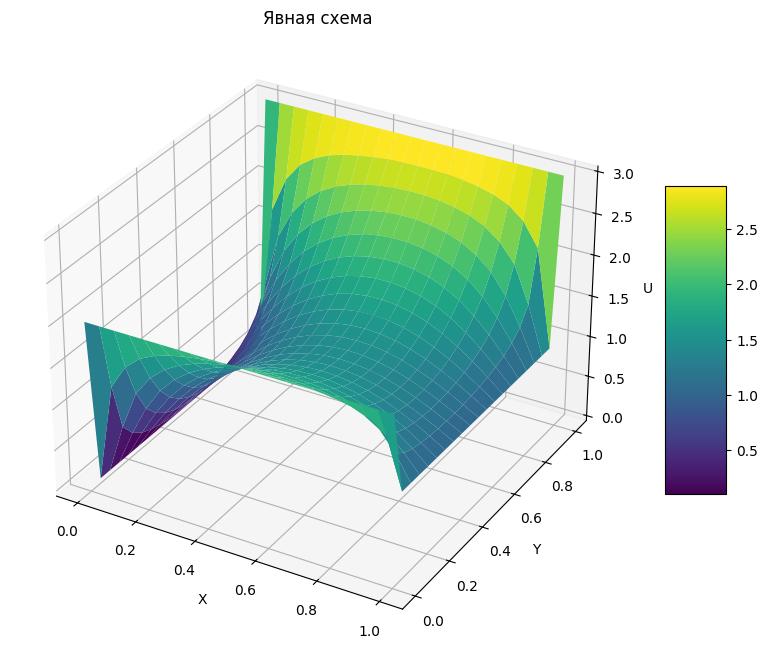

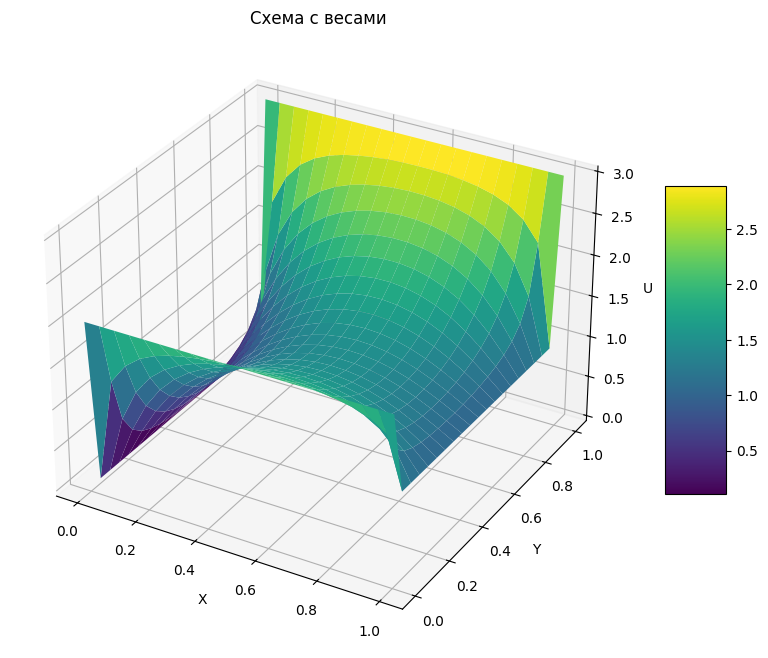

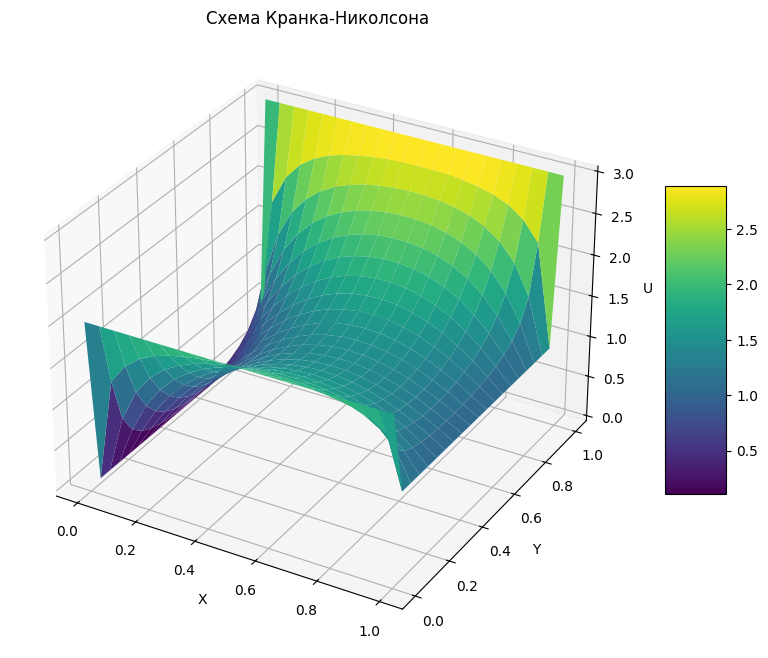

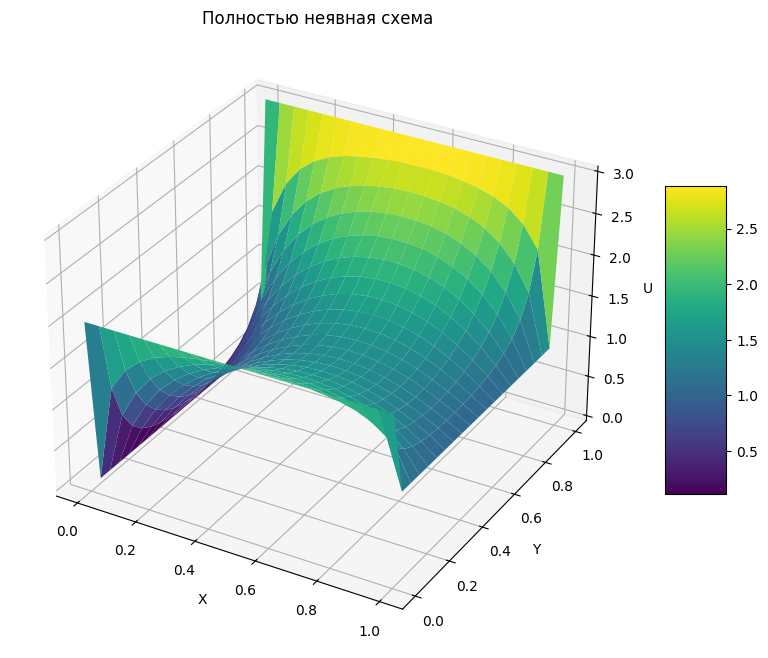

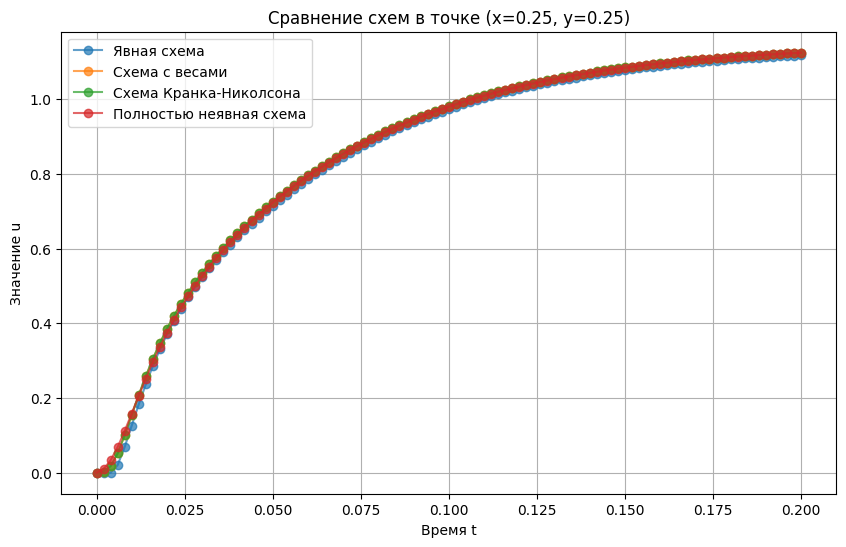

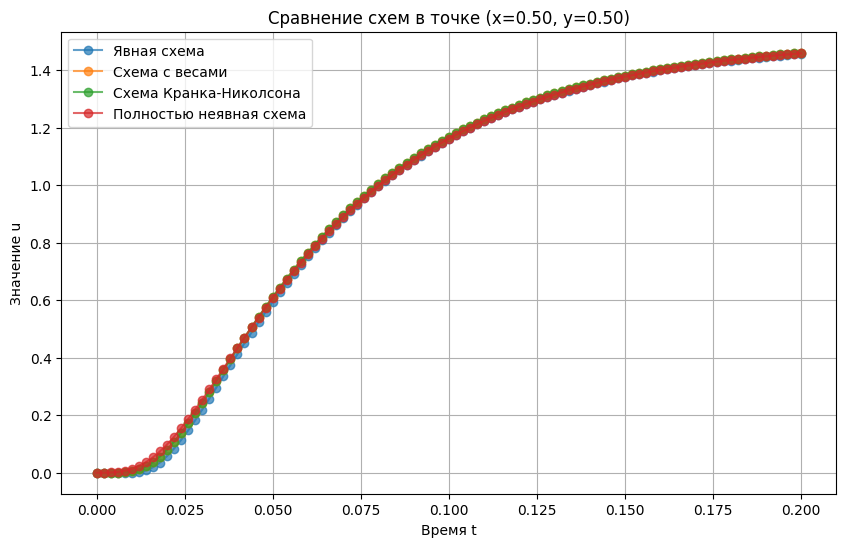

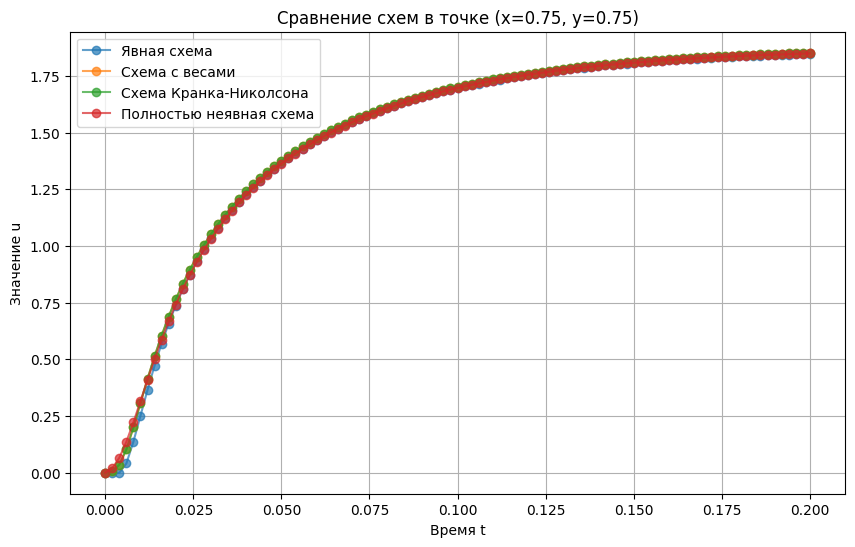


Анализ сходимости - Явная схема:

Вычисление референсного решения для Явная схема на сетке 64x64...
Шаг по времени: dt = 9.765625e-05, число временных шагов: 2048
Условие устойчивости: dt/(dx²) = 0.400000, dt/(dy²) = 0.400000 (должно быть <= 0.5)

Вычисление решения для Явная схема на сетке 4x4...
Шаг по времени: dt = 5.000000e-03, число временных шагов: 40
Условие устойчивости: dt/(dx²) = 0.080000, dt/(dy²) = 0.080000 (должно быть <= 0.5)
Явная схема - Сетка 4x4: Ошибка = 6.443424e-01

Вычисление решения для Явная схема на сетке 8x8...
Шаг по времени: dt = 2.500000e-03, число временных шагов: 80
Условие устойчивости: dt/(dx²) = 0.160000, dt/(dy²) = 0.160000 (должно быть <= 0.5)
Явная схема - Сетка 8x8: Ошибка = 3.585570e-01

Вычисление решения для Явная схема на сетке 16x16...
Шаг по времени: dt = 1.250000e-03, число временных шагов: 160
Условие устойчивости: dt/(dx²) = 0.320000, dt/(dy²) = 0.320000 (должно быть <= 0.5)
Явная схема - Сетка 16x16: Ошибка = 1.816538e-01

Вычисление реш

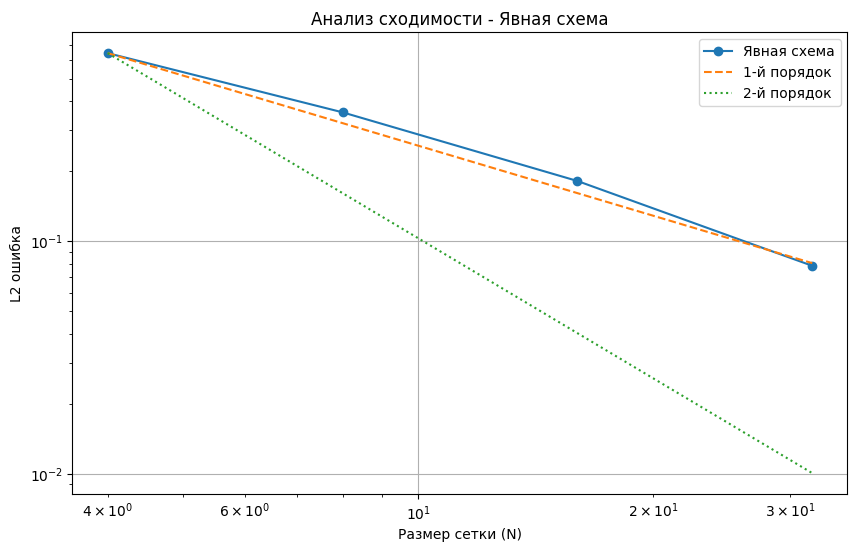


Анализ сходимости - Схема с весами:

Вычисление референсного решения для Схема с весами на сетке 64x64...
Шаг по времени: dt = 2.000000e-04, число временных шагов: 1000

Вычисление решения для Схема с весами на сетке 4x4...
Шаг по времени: dt = 5.000000e-03, число временных шагов: 40
Схема с весами - Сетка 4x4: Ошибка = 6.450381e-01

Вычисление решения для Схема с весами на сетке 8x8...
Шаг по времени: dt = 2.500000e-03, число временных шагов: 80
Схема с весами - Сетка 8x8: Ошибка = 3.591778e-01

Вычисление решения для Схема с весами на сетке 16x16...
Шаг по времени: dt = 1.250000e-03, число временных шагов: 160
Схема с весами - Сетка 16x16: Ошибка = 1.824025e-01

Вычисление решения для Схема с весами на сетке 32x32...
Шаг по времени: dt = 6.250000e-04, число временных шагов: 320
Схема с весами - Сетка 32x32: Ошибка = 7.892184e-02
Порядок сходимости от 4 до 8: 0.845
Порядок сходимости от 8 до 16: 0.978
Порядок сходимости от 16 до 32: 1.209


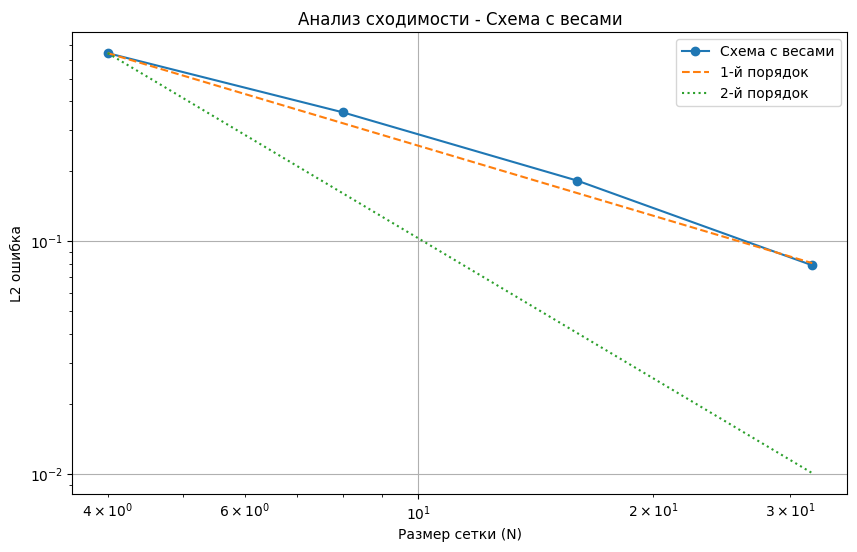


Анализ сходимости - Схема Кранка-Николсона:

Вычисление референсного решения для Схема Кранка-Николсона на сетке 64x64...
Шаг по времени: dt = 2.000000e-04, число временных шагов: 1000

Вычисление решения для Схема Кранка-Николсона на сетке 4x4...
Шаг по времени: dt = 5.000000e-03, число временных шагов: 40
Схема Кранка-Николсона - Сетка 4x4: Ошибка = 6.450381e-01

Вычисление решения для Схема Кранка-Николсона на сетке 8x8...
Шаг по времени: dt = 2.500000e-03, число временных шагов: 80
Схема Кранка-Николсона - Сетка 8x8: Ошибка = 3.591778e-01

Вычисление решения для Схема Кранка-Николсона на сетке 16x16...
Шаг по времени: dt = 1.250000e-03, число временных шагов: 160
Схема Кранка-Николсона - Сетка 16x16: Ошибка = 1.824025e-01

Вычисление решения для Схема Кранка-Николсона на сетке 32x32...
Шаг по времени: dt = 6.250000e-04, число временных шагов: 320
Схема Кранка-Николсона - Сетка 32x32: Ошибка = 7.892184e-02
Порядок сходимости от 4 до 8: 0.845
Порядок сходимости от 8 до 16: 0.978
Пор

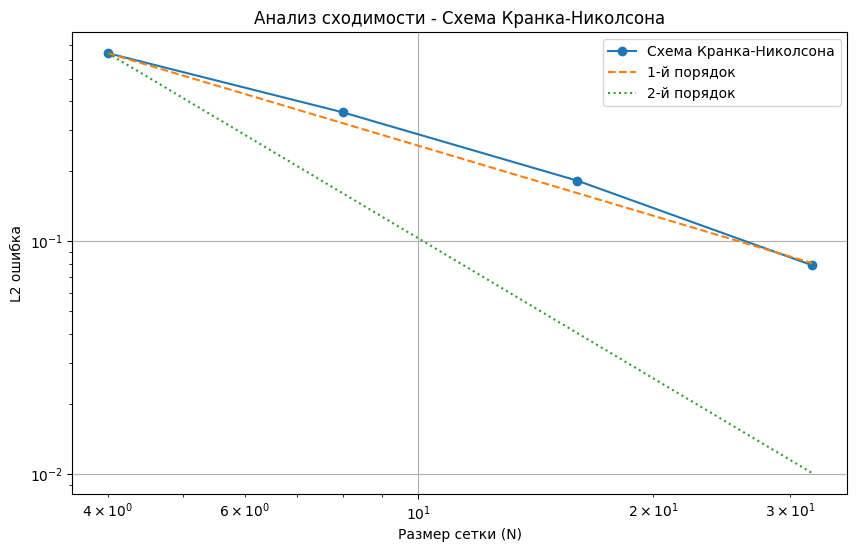


Анализ сходимости - Полностью неявная схема:

Вычисление референсного решения для Полностью неявная схема на сетке 64x64...
Шаг по времени: dt = 2.000000e-04, число временных шагов: 1000

Вычисление решения для Полностью неявная схема на сетке 4x4...
Шаг по времени: dt = 5.000000e-03, число временных шагов: 40
Полностью неявная схема - Сетка 4x4: Ошибка = 6.449269e-01

Вычисление решения для Полностью неявная схема на сетке 8x8...
Шаг по времени: dt = 2.500000e-03, число временных шагов: 80
Полностью неявная схема - Сетка 8x8: Ошибка = 3.588398e-01

Вычисление решения для Полностью неявная схема на сетке 16x16...
Шаг по времени: dt = 1.250000e-03, число временных шагов: 160
Полностью неявная схема - Сетка 16x16: Ошибка = 1.821733e-01

Вычисление решения для Полностью неявная схема на сетке 32x32...
Шаг по времени: dt = 6.250000e-04, число временных шагов: 320
Полностью неявная схема - Сетка 32x32: Ошибка = 7.911518e-02
Порядок сходимости от 4 до 8: 0.846
Порядок сходимости от 8 до 16:

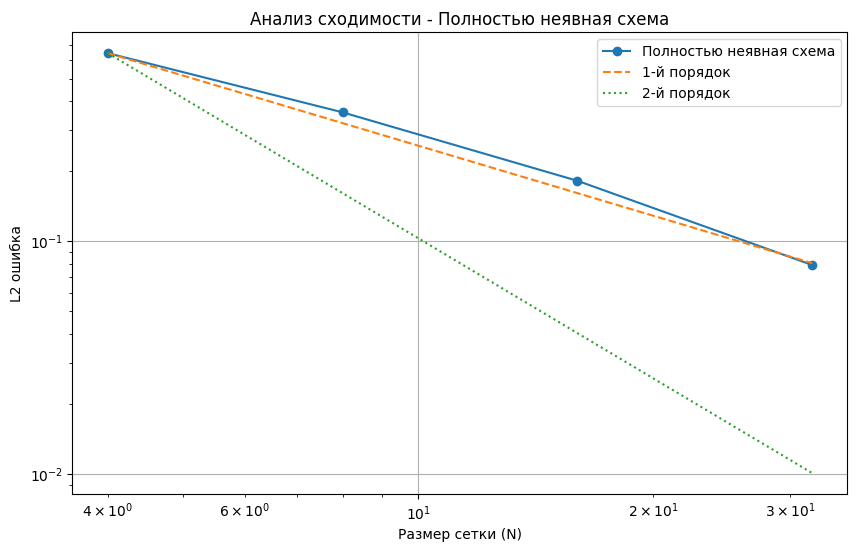


Получение данных для сравнительного графика...

Вычисление референсного решения для Явная схема на сетке 64x64...
Шаг по времени: dt = 9.765625e-05, число временных шагов: 2048
Условие устойчивости: dt/(dx²) = 0.400000, dt/(dy²) = 0.400000 (должно быть <= 0.5)

Вычисление решения для Явная схема на сетке 4x4...
Шаг по времени: dt = 5.000000e-03, число временных шагов: 40
Условие устойчивости: dt/(dx²) = 0.080000, dt/(dy²) = 0.080000 (должно быть <= 0.5)
Явная схема - Сетка 4x4: Ошибка = 6.443424e-01

Вычисление решения для Явная схема на сетке 8x8...
Шаг по времени: dt = 2.500000e-03, число временных шагов: 80
Условие устойчивости: dt/(dx²) = 0.160000, dt/(dy²) = 0.160000 (должно быть <= 0.5)
Явная схема - Сетка 8x8: Ошибка = 3.585570e-01

Вычисление решения для Явная схема на сетке 16x16...
Шаг по времени: dt = 1.250000e-03, число временных шагов: 160
Условие устойчивости: dt/(dx²) = 0.320000, dt/(dy²) = 0.320000 (должно быть <= 0.5)
Явная схема - Сетка 16x16: Ошибка = 1.816538e-01



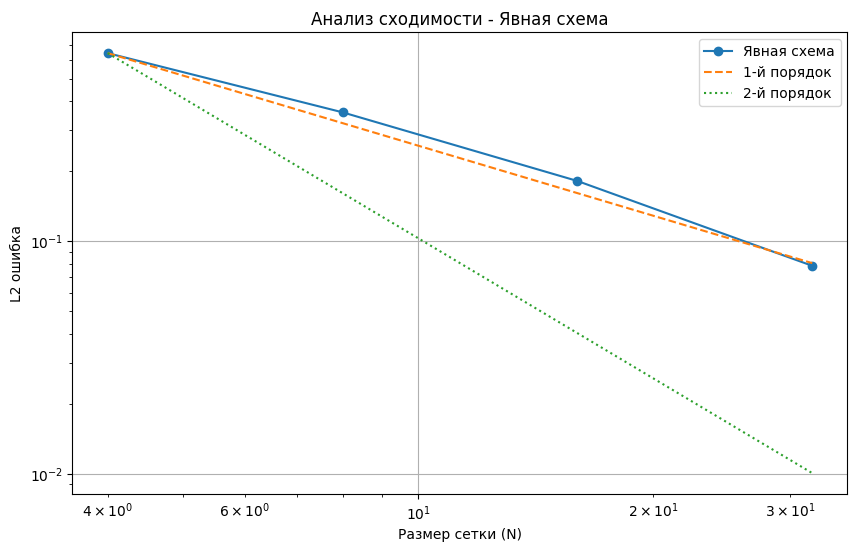


Вычисление референсного решения для Схема с весами на сетке 64x64...
Шаг по времени: dt = 2.000000e-04, число временных шагов: 1000

Вычисление решения для Схема с весами на сетке 4x4...
Шаг по времени: dt = 5.000000e-03, число временных шагов: 40
Схема с весами - Сетка 4x4: Ошибка = 6.450381e-01

Вычисление решения для Схема с весами на сетке 8x8...
Шаг по времени: dt = 2.500000e-03, число временных шагов: 80
Схема с весами - Сетка 8x8: Ошибка = 3.591778e-01

Вычисление решения для Схема с весами на сетке 16x16...
Шаг по времени: dt = 1.250000e-03, число временных шагов: 160
Схема с весами - Сетка 16x16: Ошибка = 1.824025e-01

Вычисление решения для Схема с весами на сетке 32x32...
Шаг по времени: dt = 6.250000e-04, число временных шагов: 320
Схема с весами - Сетка 32x32: Ошибка = 7.892184e-02
Порядок сходимости от 4 до 8: 0.845
Порядок сходимости от 8 до 16: 0.978
Порядок сходимости от 16 до 32: 1.209


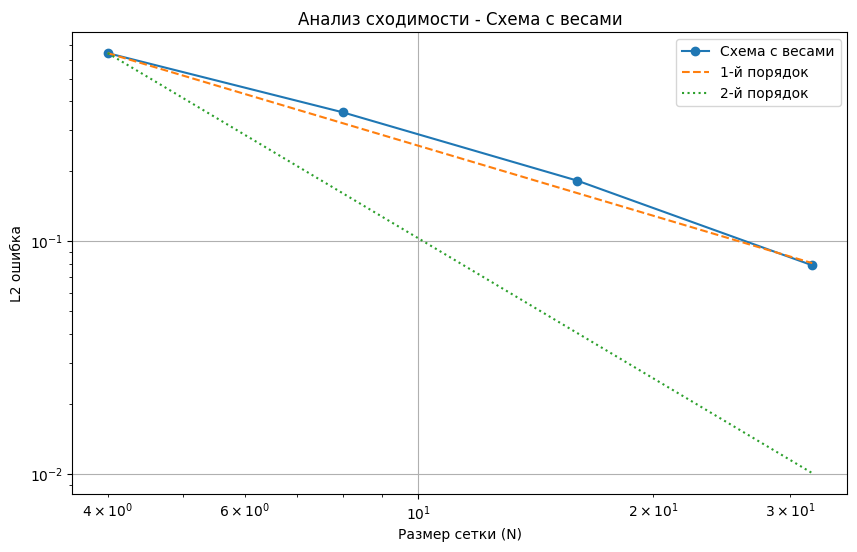


Вычисление референсного решения для Схема Кранка-Николсона на сетке 64x64...
Шаг по времени: dt = 2.000000e-04, число временных шагов: 1000

Вычисление решения для Схема Кранка-Николсона на сетке 4x4...
Шаг по времени: dt = 5.000000e-03, число временных шагов: 40
Схема Кранка-Николсона - Сетка 4x4: Ошибка = 6.450381e-01

Вычисление решения для Схема Кранка-Николсона на сетке 8x8...
Шаг по времени: dt = 2.500000e-03, число временных шагов: 80
Схема Кранка-Николсона - Сетка 8x8: Ошибка = 3.591778e-01

Вычисление решения для Схема Кранка-Николсона на сетке 16x16...
Шаг по времени: dt = 1.250000e-03, число временных шагов: 160
Схема Кранка-Николсона - Сетка 16x16: Ошибка = 1.824025e-01

Вычисление решения для Схема Кранка-Николсона на сетке 32x32...
Шаг по времени: dt = 6.250000e-04, число временных шагов: 320
Схема Кранка-Николсона - Сетка 32x32: Ошибка = 7.892184e-02
Порядок сходимости от 4 до 8: 0.845
Порядок сходимости от 8 до 16: 0.978
Порядок сходимости от 16 до 32: 1.209


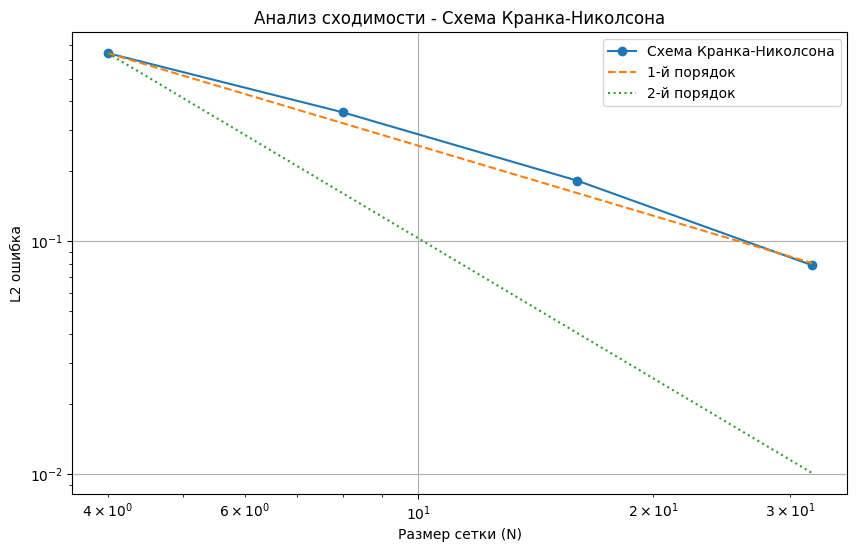


Вычисление референсного решения для Полностью неявная схема на сетке 64x64...
Шаг по времени: dt = 2.000000e-04, число временных шагов: 1000

Вычисление решения для Полностью неявная схема на сетке 4x4...
Шаг по времени: dt = 5.000000e-03, число временных шагов: 40
Полностью неявная схема - Сетка 4x4: Ошибка = 6.449269e-01

Вычисление решения для Полностью неявная схема на сетке 8x8...
Шаг по времени: dt = 2.500000e-03, число временных шагов: 80
Полностью неявная схема - Сетка 8x8: Ошибка = 3.588398e-01

Вычисление решения для Полностью неявная схема на сетке 16x16...
Шаг по времени: dt = 1.250000e-03, число временных шагов: 160
Полностью неявная схема - Сетка 16x16: Ошибка = 1.821733e-01

Вычисление решения для Полностью неявная схема на сетке 32x32...
Шаг по времени: dt = 6.250000e-04, число временных шагов: 320
Полностью неявная схема - Сетка 32x32: Ошибка = 7.911518e-02
Порядок сходимости от 4 до 8: 0.846
Порядок сходимости от 8 до 16: 0.978
Порядок сходимости от 16 до 32: 1.203


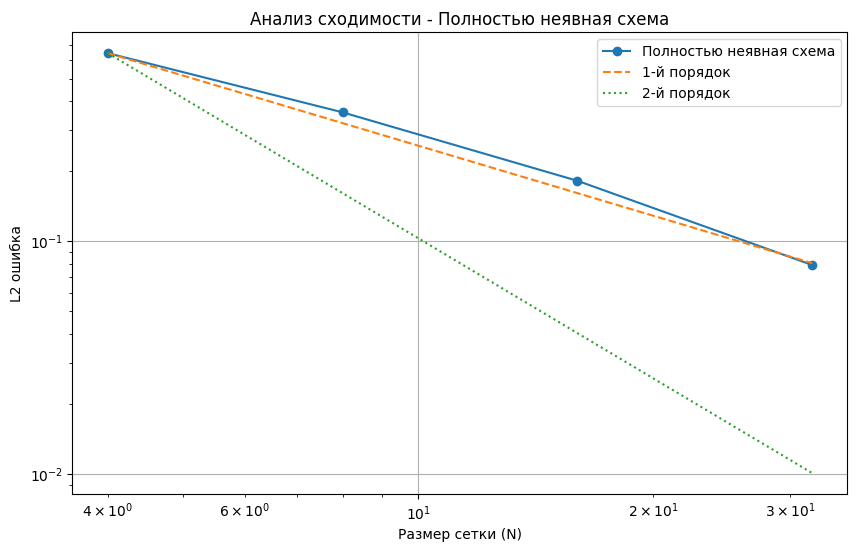

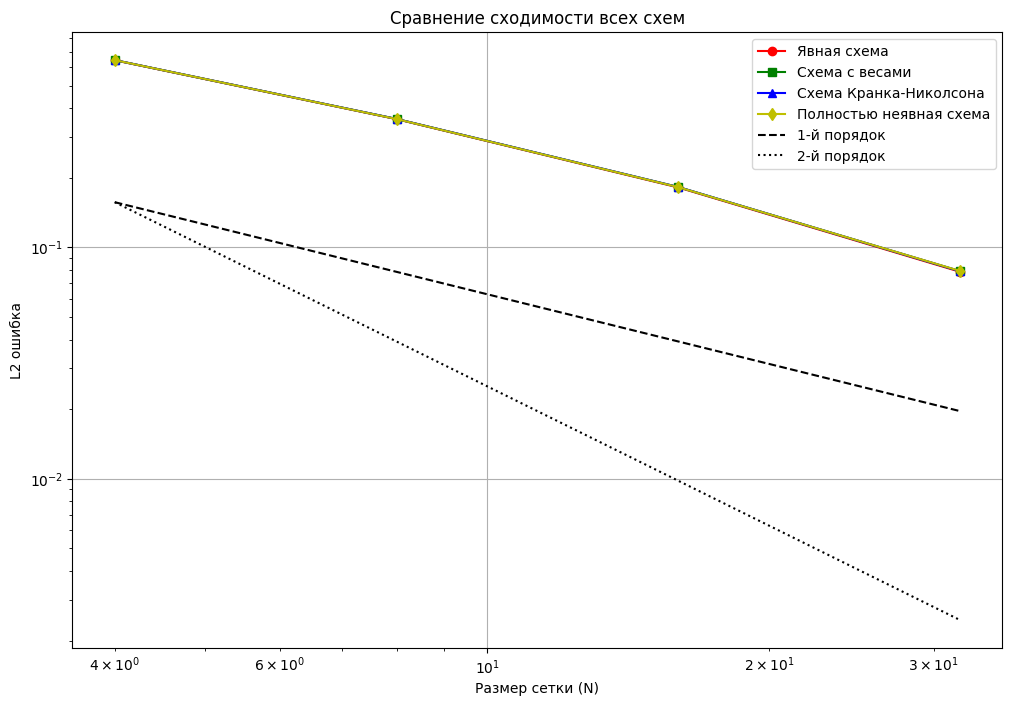

In [16]:
Nx = 20
Ny = 20
Nt = 100

print("Решение уравнения теплопроводности...")

print("\nЯвная схема:")
u_explicit_hist, x, y = solve_explicit_scheme(Nx, Ny, Nt)

print("\nСхема с весами:")
u_weighted_hist, x, y = solve_weighted_scheme(Nx, Ny, Nt)

print("\nСхема Кранка-Николсона:")
u_crank_nicolson_hist, x, y = solve_crank_nicolson_scheme(Nx, Ny, Nt)

print("\nПолностью неявная схема:")
u_implicit_hist, x, y = solve_fully_implicit_scheme(Nx, Ny, Nt)

plot_solution(u_explicit_hist[-1], x, y, "Явная схема")
plot_solution(u_weighted_hist[-1], x, y, "Схема с весами")
plot_solution(u_crank_nicolson_hist[-1], x, y, "Схема Кранка-Николсона")
plot_solution(u_implicit_hist[-1], x, y, "Полностью неявная схема")

schemes_results = [u_explicit_hist, u_weighted_hist, u_crank_nicolson_hist, u_implicit_hist]
points = [(Nx//4, Ny//4), (Nx//2, Ny//2), (3*Nx//4, 3*Ny//4)]
compare_schemes_at_points(x, y, schemes_results, points)

print("\nАнализ сходимости - Явная схема:")
analyze_convergence(solve_explicit_scheme, "Явная схема")

print("\nАнализ сходимости - Схема с весами:")
analyze_convergence(solve_weighted_scheme, "Схема с весами")

print("\nАнализ сходимости - Схема Кранка-Николсона:")
analyze_convergence(solve_crank_nicolson_scheme, "Схема Кранка-Николсона")

print("\nАнализ сходимости - Полностью неявная схема:")
analyze_convergence(solve_fully_implicit_scheme, "Полностью неявная схема")

grid_sizes = [4, 8, 16, 32]

print("\nПолучение данных для сравнительного графика...")

errors_explicit, _ = analyze_convergence(solve_explicit_scheme, "Явная схема")
errors_weighted, _ = analyze_convergence(solve_weighted_scheme, "Схема с весами")
errors_crank_nicolson, _ = analyze_convergence(solve_crank_nicolson_scheme, "Схема Кранка-Николсона")
errors_implicit, _ = analyze_convergence(solve_fully_implicit_scheme, "Полностью неявная схема")

plt.figure(figsize=(12, 8))
plt.loglog(grid_sizes, errors_explicit, 'ro-', label='Явная схема')
plt.loglog(grid_sizes, errors_weighted, 'gs-', label='Схема с весами')
plt.loglog(grid_sizes, errors_crank_nicolson, 'b^-', label='Схема Кранка-Николсона')
plt.loglog(grid_sizes, errors_implicit, 'yd-', label='Полностью неявная схема')

min_grid = grid_sizes[0]
max_grid = grid_sizes[-1]
ref_grids = np.logspace(np.log10(min_grid), np.log10(max_grid), 100)

all_errors = np.concatenate([errors_explicit, errors_weighted, errors_crank_nicolson, errors_implicit])
min_error = np.min(all_errors)

scale_factor_1st = min_error * 2 / (min_grid ** -1)
scale_factor_2nd = min_error * 2 / (min_grid ** -2)

plt.loglog(ref_grids, scale_factor_1st * ref_grids ** -1, 'k--', label='1-й порядок')
plt.loglog(ref_grids, scale_factor_2nd * ref_grids ** -2, 'k:', label='2-й порядок')

plt.xlabel('Размер сетки (N)')
plt.ylabel('L2 ошибка')
plt.title('Сравнение сходимости всех схем')
plt.grid(True)
plt.legend()

plt.show()



# Part III

12. реализовано сравнение различных разностных схем для решения линейного одномерного уравнения переноса:

∂u/∂t + c∂u/∂x = 0

1. **Схема Куранта-Изаксона-Риса** 
   ```
   u^(n+1)_i = u^n_i - c*dt/dx * (u^n_i - u^n_(i-1))
   ```

2. **Схема Мак-Кормака** 
   ```
   u*_i = u^n_i - c*dt/dx * (u^n_(i+1) - u^n_i)
   u^(n+1)_i = 0.5 * (u^n_i + u*_i - c*dt/dx * (u*_i - u*_(i-1)))
   ```

3. **Гибридная схема Федоренко** 
   ```
   u^(n+1)_i = (1-ε) * (u^n_i - c*dt/(2*dx) * (u^n_(i+1) - u^n_(i-1))) + 
              ε * (u^n_i - c*dt/dx * (u^n_i - u^n_(i-1)))
   ```

4. **TVD схема** 
   ```
   u^(n+1)_i = u^n_i - dt/dx * (f_i - f_(i-1)) - 
              c*dt/dx * (0.5*φ^+_i * (1-c*dt/dx) * (u^n_i - u^n_(i-1)) - 
                       0.5*φ^-_i * (1-c*dt/dx) * (u^n_(i-1) - u^n_(i-2)))
   ```
   где φ - ограничитель потока minmod

Исследование проводится для двух начальных профилей:

1. **Прямоугольный импульс**
   ```
   u(0,x) = 1, если x ∈ [0.25, 0.5]
   u(0,x) = 0, иначе
   ```

2. **Треугольный импульс**
   ```
   u(0,x) = 4(x-0.25), если x ∈ [0.25, 0.375]
   u(0,x) = 4(0.5-x), если x ∈ (0.375, 0.5]
   u(0,x) = 0, иначе
   ```


Для уравнения переноса с постоянным коэффициентом c аналитическое решение имеет вид:
```
u(t,x) = u(0, x-c*t)
```


In [20]:
from matplotlib.animation import FuncAnimation

T_max = 1.0  
X_max = 1.0  
c = 1.0      

CFL = 0.8    

# Функции начальных профилей
def rectangular_init(x):
    """Прямоугольный импульс"""
    u = np.zeros_like(x)
    mask = (x >= 0.25) & (x <= 0.5)
    u[mask] = 1.0
    return u

def triangular_init(x):
    """Треугольный импульс"""
    u = np.zeros_like(x)
    mask1 = (x >= 0.25) & (x <= 0.375)
    mask2 = (x > 0.375) & (x <= 0.5)
    
    # Восходящая часть
    u[mask1] = 4.0 * (x[mask1] - 0.25)
    
    # Нисходящая часть
    u[mask2] = 4.0 * (0.5 - x[mask2])
    
    return u

def analytical_solution(x, t, init_func):
    """Аналитическое решение: u(x,t) = u0(x - c*t)"""
    x_shifted = (x - c * t) % X_max
    return init_func(x_shifted)



In [22]:
def upwind_scheme(u, dt, dx, Nx):
    """
    Куранта-Изаксона-Риса первого порядка
    """
    u_new = np.copy(u)
    
    for i in range(Nx):
        i_prev = (i - 1) % Nx  
        
        u_new[i] = u[i] - c * dt / dx * (u[i] - u[i_prev])
    
    return u_new

def maccormack_scheme(u, dt, dx, Nx):
    """
    Схема Мак-Кормака 
    """
    u_star = np.zeros_like(u)
    u_new = np.zeros_like(u)
    
    # Предиктор 
    for i in range(Nx):
        i_next = (i + 1) % Nx
        u_star[i] = u[i] - c * dt / dx * (u[i_next] - u[i])
    
    # Корректор 
    for i in range(Nx):
        i_prev = (i - 1) % Nx
        u_new[i] = 0.5 * (u[i] + u_star[i] - c * dt / dx * (u_star[i] - u_star[i_prev]))
    
    return u_new

def fedorenko_scheme(u, dt, dx, Nx, epsilon=0.05):
    """
    Гибридная схема Федоренко
    """
    u_new = np.zeros_like(u)
    
    for i in range(Nx):
        i_prev = (i - 1) % Nx
        i_next = (i + 1) % Nx
        
        # против потока
        upwind_part = u[i] - c * dt / dx * (u[i] - u[i_prev])
        
        # с центральными разностями
        central_part = u[i] - c * dt / (2 * dx) * (u[i_next] - u[i_prev])
        
        # гибридная 
        u_new[i] = (1 - epsilon) * central_part + epsilon * upwind_part
    
    return u_new

def minmod(a, b):
    """
    Minmod ограничитель для TVD схемы
    """
    if a * b > 0:
        return np.sign(a) * min(abs(a), abs(b))
    else:
        return 0

def tvd_scheme(u, dt, dx, Nx):
    """
    TVD схема (Total Variation Diminishing)
    """
    u_new = np.zeros_like(u)
    
    for i in range(Nx):
        i_prev = (i - 1) % Nx
        i_next = (i + 1) % Nx
        i_prev2 = (i - 2) % Nx
        
        r_minus = (u[i] - u[i_prev2]) / (u[i_prev] - u[i_prev2] + 1e-10)
        r_plus = (u[i_next] - u[i]) / (u[i] - u[i_prev] + 1e-10)
        
        phi_minus = max(0, min(1, r_minus))
        phi_plus = max(0, min(1, r_plus))
        
        f_minus = c * u[i_prev]
        f_plus = c * u[i]
        
        u_new[i] = u[i] - dt / dx * (f_plus - f_minus) - \
                  c * dt / dx * (0.5 * phi_plus * (1 - c * dt / dx) * (u[i] - u[i_prev]) - \
                               0.5 * phi_minus * (1 - c * dt / dx) * (u[i_prev] - u[i_prev2]))
    
    return u_new

def solve_equation(init_func, Nx, scheme_func, T_final=T_max):
    """
    Решение уравнения переноса с заданной схемой и начальным условием
    """
    dx = X_max / Nx
    dt = CFL * dx / c  
    Nt = int(T_final / dt)
    
    x = np.linspace(0, X_max, Nx, endpoint=False)
    
    u = init_func(x)
    u_history = [u.copy()]
    
    for n in range(Nt):
        u = scheme_func(u, dt, dx, Nx)
        
        if n % max(1, Nt // 100) == 0 or n == Nt - 1:
            u_history.append(u.copy())
    
    return u_history, x, dt

def calculate_error(u_numerical, u_exact):
    error_l1 = np.mean(np.abs(u_numerical - u_exact))
    
    error_l2 = np.sqrt(np.mean((u_numerical - u_exact)**2))
    
    error_inf = np.max(np.abs(u_numerical - u_exact))
    
    return error_l1, error_l2, error_inf

def analyze_convergence(init_func, scheme_func, scheme_name):
    grid_sizes = [50, 100, 200, 400, 800]
    errors_l1 = []
    errors_l2 = []
    errors_inf = []
    
    for Nx in grid_sizes:
        print(f"Расчет {scheme_name} на сетке {Nx} точек...")
        u_history, x, dt = solve_equation(init_func, Nx, scheme_func)
        
        t_final = len(u_history) * dt
        u_exact = analytical_solution(x, t_final, init_func)
        
        error_l1, error_l2, error_inf = calculate_error(u_history[-1], u_exact)
        errors_l1.append(error_l1)
        errors_l2.append(error_l2)
        errors_inf.append(error_inf)
        
        print(f"  L1 ошибка: {error_l1:.6e}")
        print(f"  L2 ошибка: {error_l2:.6e}")
        print(f"  L-inf ошибка: {error_inf:.6e}")
    
    orders_l1 = []
    orders_l2 = []
    orders_inf = []
    
    for i in range(1, len(grid_sizes)):
        ratio = grid_sizes[i] / grid_sizes[i-1]
        
        order_l1 = np.log(errors_l1[i-1] / errors_l1[i]) / np.log(ratio)
        order_l2 = np.log(errors_l2[i-1] / errors_l2[i]) / np.log(ratio)
        order_inf = np.log(errors_inf[i-1] / errors_inf[i]) / np.log(ratio)
        
        orders_l1.append(order_l1)
        orders_l2.append(order_l2)
        orders_inf.append(order_inf)
        
        print(f"Порядок сходимости от {grid_sizes[i-1]} до {grid_sizes[i]} точек:")
        print(f"  L1: {order_l1:.3f}")
        print(f"  L2: {order_l2:.3f}")
        print(f"  L-inf: {order_inf:.3f}")
    
    return grid_sizes, errors_l1, errors_l2, errors_inf, orders_l1, orders_l2, orders_inf

def plot_solutions(init_func, Nx=200):
    schemes = [
        (upwind_scheme, "Схема Куранта-Изаксона-Риса"),
        (maccormack_scheme, "Схема Мак-Кормака"),
        (fedorenko_scheme, "Гибридная схема Федоренко"),
        (tvd_scheme, "TVD схема")
    ]
    
    results = []
    x = None
    dt = None
    
    for scheme_func, scheme_name in schemes:
        print(f"Расчет {scheme_name}...")
        u_history, x, dt = solve_equation(init_func, Nx, scheme_func)
        results.append((u_history, scheme_name))
    
    t_final = len(results[0][0]) * dt
    u_exact = analytical_solution(x, t_final, init_func)
    
    plt.figure(figsize=(12, 8))
    plt.plot(x, init_func(x), 'k--', label='Начальное условие')
    plt.plot(x, u_exact, 'k-', label='Аналитическое решение')
    
    colors = ['r', 'g', 'b', 'c']
    markers = ['o', 's', '^', 'd']
    
    for i, (u_history, scheme_name) in enumerate(results):
        plt.plot(x, u_history[-1], colors[i], marker=markers[i], 
                 markevery=max(1, Nx//20), label=scheme_name, alpha=0.7)
    
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(f'Сравнение численных схем в момент t = {t_final:.2f}')
    plt.legend()
    plt.grid(True)
    
    init_type = "rectangular" if np.array_equal(init_func(x), rectangular_init(x)) else "triangular"
    plt.show()
    
    plt.figure(figsize=(12, 8))
    
    for i, (u_history, scheme_name) in enumerate(results):
        error = np.abs(u_history[-1] - u_exact)
        plt.semilogy(x, error + 1e-15, colors[i], marker=markers[i],
                   markevery=max(1, Nx//20), label=scheme_name, alpha=0.7)
    
    plt.xlabel('x')
    plt.ylabel('Абсолютная ошибка')
    plt.title(f'Ошибки численных схем в момент t = {t_final:.2f}')
    plt.legend()
    plt.grid(True)
    
    plt.show()
    
    return results, x, dt

def plot_convergence(init_func):
    schemes = [
        (upwind_scheme, "Схема Куранта-Изаксона-Риса"),
        (maccormack_scheme, "Схема Мак-Кормака"),
        (fedorenko_scheme, "Гибридная схема Федоренко"),
        (tvd_scheme, "TVD схема")
    ]
    
    plt.figure(figsize=(12, 8))
    colors = ['r', 'g', 'b', 'c']
    markers = ['o', 's', '^', 'd']
    
    for i, (scheme_func, scheme_name) in enumerate(schemes):
        print(f"\nАнализ сходимости для {scheme_name}...")
        grid_sizes, errors_l1, errors_l2, errors_inf, _, _, _ = analyze_convergence(
            init_func, scheme_func, scheme_name)
        
        plt.loglog(grid_sizes, errors_l2, colors[i], marker=markers[i], 
                  label=scheme_name, alpha=0.7)
    
    x_ref = np.array([grid_sizes[0], grid_sizes[-1]])
    y_ref1 = errors_l2[0] * (grid_sizes[0] / x_ref)
    y_ref2 = errors_l2[0] * (grid_sizes[0] / x_ref)**2
    
    plt.loglog(x_ref, y_ref1, 'k--', label='1-й порядок')
    plt.loglog(x_ref, y_ref2, 'k:', label='2-й порядок')
    
    plt.xlabel('Количество точек (Nx)')
    plt.ylabel('L2 ошибка')
    plt.title('Анализ сходимости различных схем')
    plt.legend()
    plt.grid(True)
    
    init_type = "rectangular" if np.array_equal(init_func(np.linspace(0, 1, 100)), 
                                              rectangular_init(np.linspace(0, 1, 100))) else "triangular"
    plt.show()

def create_animation(init_func, Nx=200, scheme_func=tvd_scheme, scheme_name="TVD"):
    u_history, x, dt = solve_equation(init_func, Nx, scheme_func)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    line_num, = ax.plot([], [], 'b-', label='Численное решение')
    line_exact, = ax.plot([], [], 'r--', label='Аналитическое решение')
    
    ax.set_xlim(0, X_max)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title(f'{scheme_name}')
    ax.legend()
    ax.grid(True)
    
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    
    def init():
        line_num.set_data([], [])
        line_exact.set_data([], [])
        time_text.set_text('')
        return line_num, line_exact, time_text
    
    def update(frame):
        t = frame * dt
        
        line_num.set_data(x, u_history[frame])
        
        u_exact = analytical_solution(x, t, init_func)
        line_exact.set_data(x, u_exact)
        
        time_text.set_text(f't = {t:.3f}')
        return line_num, line_exact, time_text
    
    ani = FuncAnimation(fig, update, frames=range(0, len(u_history), max(1, len(u_history)//100)),
                       init_func=init, blit=True, repeat=False)
    
    init_type = "rectangular" if np.array_equal(init_func(x), rectangular_init(x)) else "triangular"
    ani.save(f'animation_{init_type}_{scheme_name}.mp4', writer='ffmpeg', fps=15)
    
    plt.close()

Сравнение численных схем для решения уравнения переноса

=== Прямоугольный начальный профиль ===
Расчет Схема Куранта-Изаксона-Риса...
Расчет Схема Мак-Кормака...
Расчет Гибридная схема Федоренко...
Расчет TVD схема...


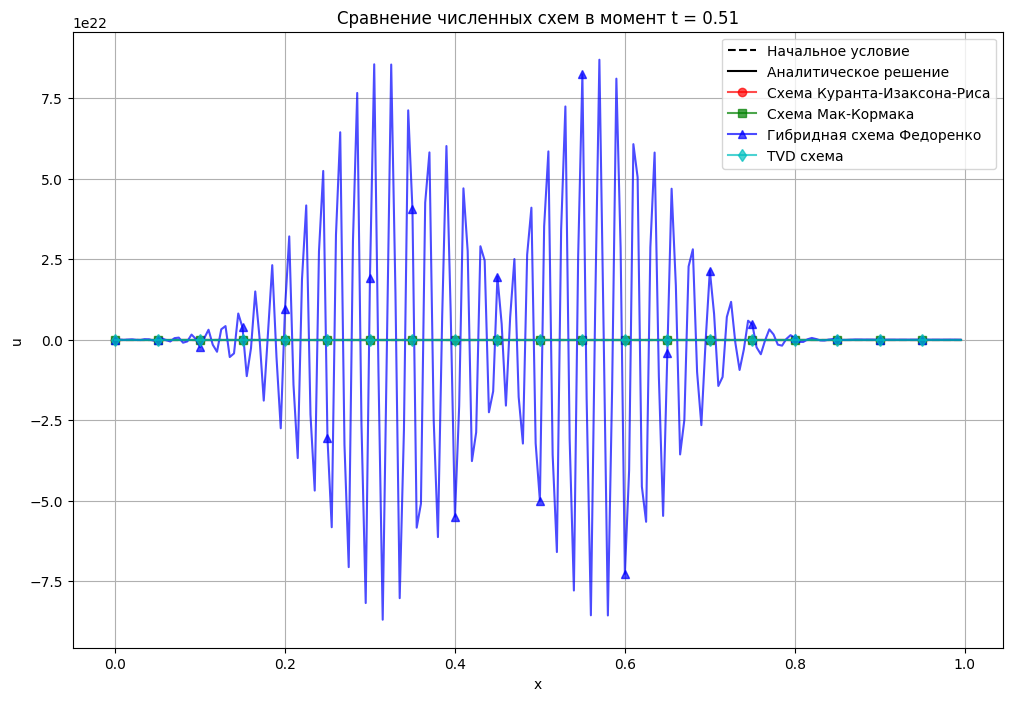

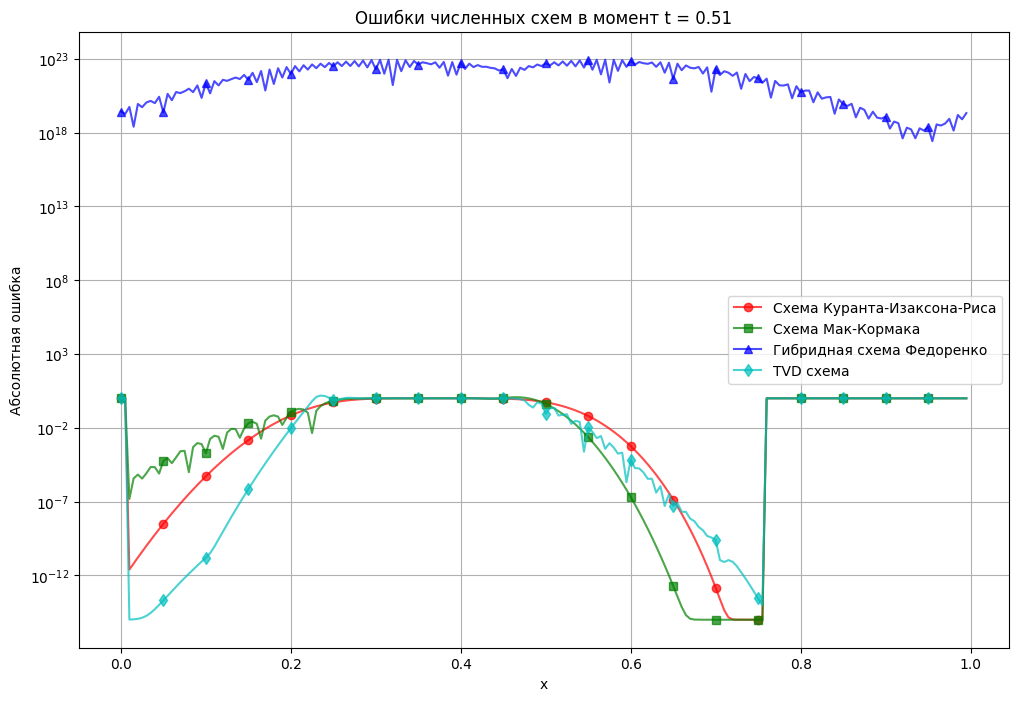


=== Треугольный начальный профиль ===
Расчет Схема Куранта-Изаксона-Риса...
Расчет Схема Мак-Кормака...
Расчет Гибридная схема Федоренко...
Расчет TVD схема...


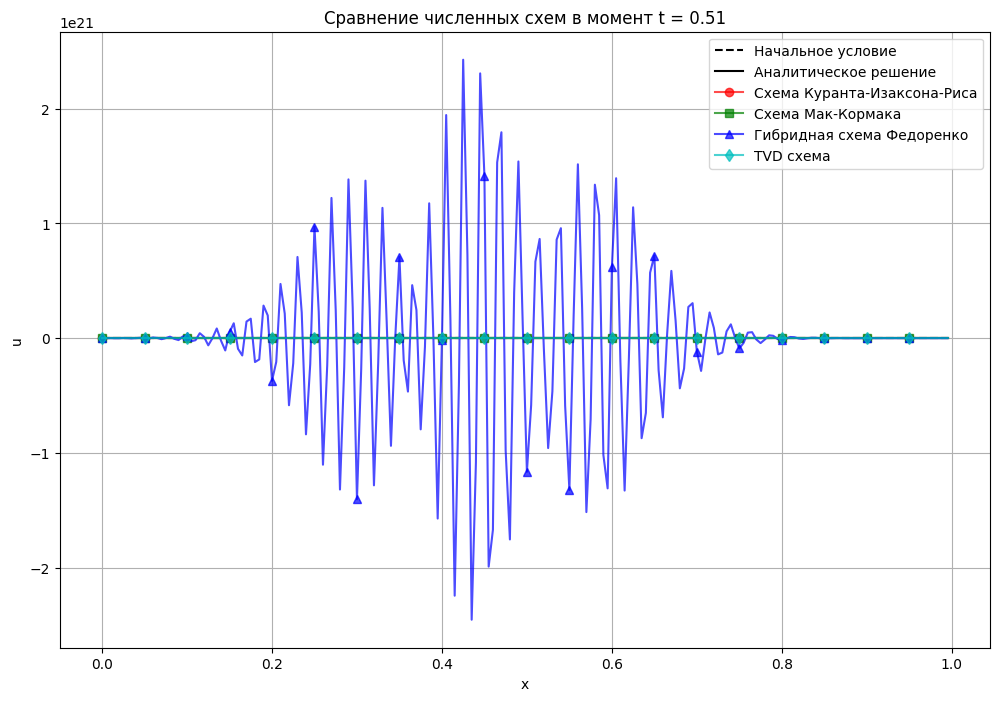

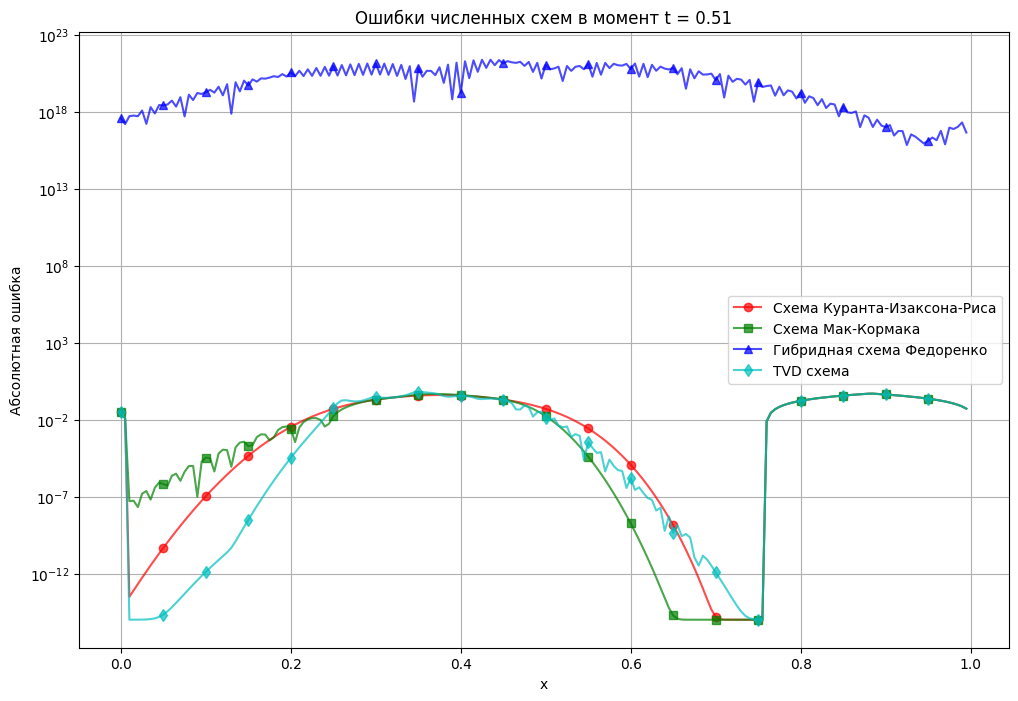


=== Анализ сходимости для прямоугольного профиля ===

Анализ сходимости для Схема Куранта-Изаксона-Риса...
Расчет Схема Куранта-Изаксона-Риса на сетке 50 точек...
  L1 ошибка: 1.002089e-01
  L2 ошибка: 1.718221e-01
  L-inf ошибка: 4.745845e-01
Расчет Схема Куранта-Изаксона-Риса на сетке 100 точек...
  L1 ошибка: 7.182849e-02
  L2 ошибка: 1.465396e-01
  L-inf ошибка: 5.356427e-01
Расчет Схема Куранта-Изаксона-Риса на сетке 200 точек...
  L1 ошибка: 5.050000e-01
  L2 ошибка: 6.850952e-01
  L-inf ошибка: 1.000000e+00
Расчет Схема Куранта-Изаксона-Риса на сетке 400 точек...
  L1 ошибка: 4.071875e-01
  L2 ошибка: 6.180369e-01
  L-inf ошибка: 1.000000e+00
Расчет Схема Куранта-Изаксона-Риса на сетке 800 точек...
  L1 ошибка: 2.037500e-01
  L2 ошибка: 4.311769e-01
  L-inf ошибка: 1.000000e+00
Порядок сходимости от 50 до 100 точек:
  L1: 0.480
  L2: 0.230
  L-inf: -0.175
Порядок сходимости от 100 до 200 точек:
  L1: -2.814
  L2: -2.225
  L-inf: -0.901
Порядок сходимости от 200 до 400 точек:
  

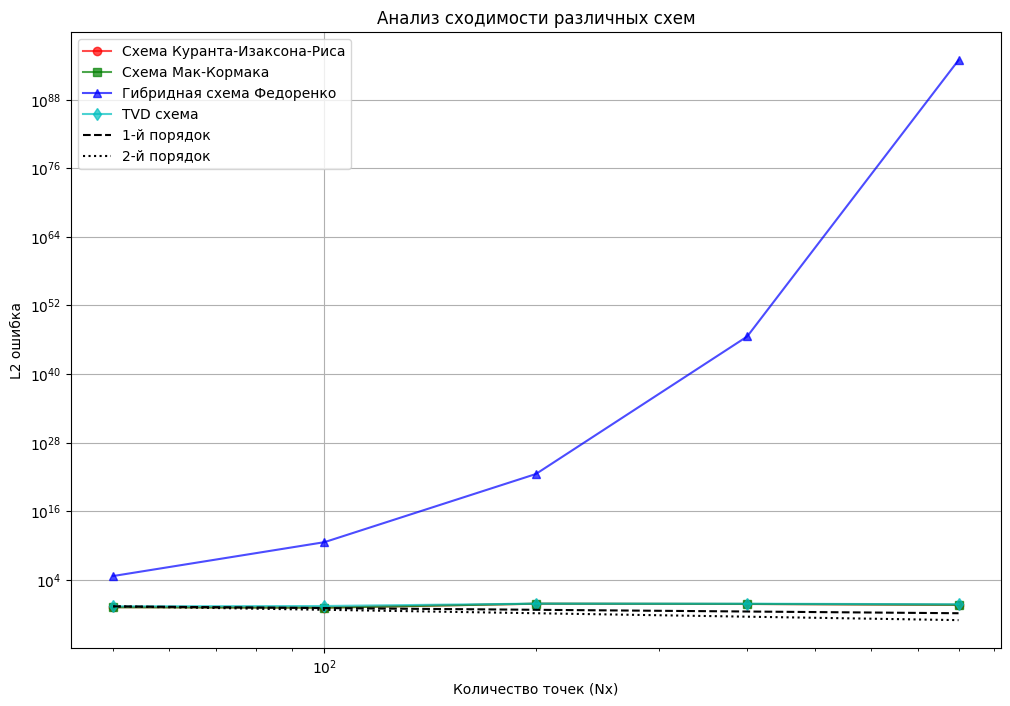


=== Анализ сходимости для треугольного профиля ===

Анализ сходимости для Схема Куранта-Изаксона-Риса...
Расчет Схема Куранта-Изаксона-Риса на сетке 50 точек...
  L1 ошибка: 2.672660e-02
  L2 ошибка: 5.076914e-02
  L-inf ошибка: 1.870552e-01
Расчет Схема Куранта-Изаксона-Риса на сетке 100 точек...
  L1 ошибка: 1.592498e-02
  L2 ошибка: 3.213711e-02
  L-inf ошибка: 1.313119e-01
Расчет Схема Куранта-Изаксона-Риса на сетке 200 точек...
  L1 ошибка: 1.250000e-01
  L2 ошибка: 1.970029e-01
  L-inf ошибка: 4.920000e-01
Расчет Схема Куранта-Изаксона-Риса на сетке 400 точек...
  L1 ошибка: 1.189282e-01
  L2 ошибка: 1.979606e-01
  L-inf ошибка: 4.959982e-01
Расчет Схема Куранта-Изаксона-Риса на сетке 800 точек...
  L1 ошибка: 8.019262e-02
  L2 ошибка: 1.534781e-01
  L-inf ошибка: 4.056989e-01
Порядок сходимости от 50 до 100 точек:
  L1: 0.747
  L2: 0.660
  L-inf: 0.510
Порядок сходимости от 100 до 200 точек:
  L1: -2.973
  L2: -2.616
  L-inf: -1.906
Порядок сходимости от 200 до 400 точек:
  L1:

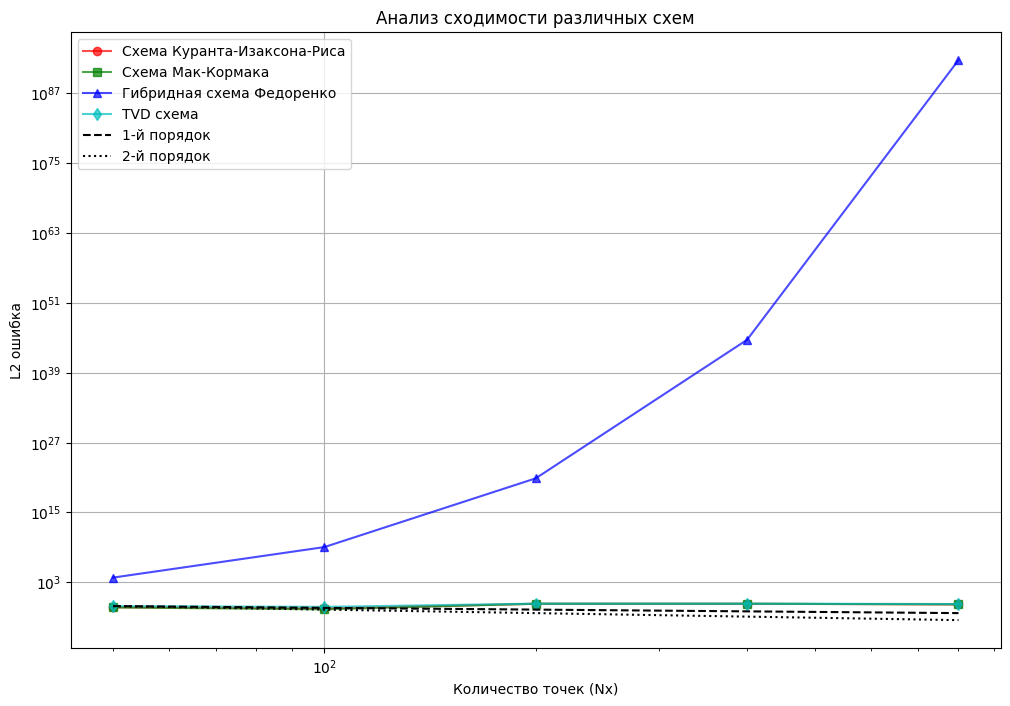


=== Создание анимаций ===

Расчет завершен. Результаты сохранены в файлы.


In [23]:
print("Сравнение численных схем для решения уравнения переноса")

print("\n=== Прямоугольный начальный профиль ===")
results_rect, x_rect, dt_rect = plot_solutions(rectangular_init)

print("\n=== Треугольный начальный профиль ===")
results_tri, x_tri, dt_tri = plot_solutions(triangular_init)

print("\n=== Анализ сходимости для прямоугольного профиля ===")
plot_convergence(rectangular_init)

print("\n=== Анализ сходимости для треугольного профиля ===")
plot_convergence(triangular_init)

print("\n=== Создание анимаций ===")
create_animation(rectangular_init, scheme_func=upwind_scheme, scheme_name="Куранта-Изаксона-Риса")
create_animation(rectangular_init, scheme_func=maccormack_scheme, scheme_name="Мак-Кормака")
create_animation(triangular_init, scheme_func=fedorenko_scheme, scheme_name="Федоренко")
create_animation(triangular_init, scheme_func=tvd_scheme, scheme_name="TVD")
print("\nРасчет завершен. Результаты сохранены в файлы.")

